<a href="https://colab.research.google.com/github/vincent4u/Plant_disease-classification-Msc_thesis-/blob/main/MobileNet_model_1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing system libraries***

In [1]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# ***Creating important functions***

*Functions to Create DataFrame from Dataset*

In [2]:
# Function to generate file paths and corresponding labels from a given directory
def define_paths(data_dir):
    """
    This function iterates through directories and subdirectories within the provided data directory,
    collecting file paths and assigning them labels based on the parent directory they reside in.

    Parameters:
    - data_dir: The root directory where the data is stored.

    Returns:
    - A tuple containing two lists: filepaths (a list of absolute paths to all files) and labels (a list of labels corresponding to each file).
    """
    filepaths = []  # List to store absolute paths of all files
    labels = []     # List to store labels for each file

    # Get a list of all folders/directories in the data directory
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)  # Construct the full path to the current folder
        filelist = os.listdir(foldpath)           # Get a list of all files in the current folder
        for file in filelist:
            fpath = os.path.join(foldpath, file)  # Construct the full path to the current file
            filepaths.append(fpath)               # Append the file path to the list
            labels.append(fold)                   # Append the label (folder name) to the list

    return filepaths, labels





# Function to concatenate file paths and labels into a single DataFrame
def define_df(files, classes):
    """
    This function creates two pandas Series objects from the provided lists of file paths and labels,
    then concatenates these series side by side into a single DataFrame. This DataFrame will serve as the input
    for further processing, such as splitting into training, validation, and testing sets.

    Parameters:
    - files: A list of file paths.
    - classes: A list of labels corresponding to each file.

    Returns:
    - A DataFrame with two columns: 'filepaths' and 'labels', where 'filepaths' contains the paths to the files
      and 'labels' contains the corresponding labels.
    """
    Fseries = pd.Series(files, name='filepaths')  # Create a Series object for file paths
    Lseries = pd.Series(classes, name='labels')   # Create a Series object for labels
    return pd.concat([Fseries, Lseries], axis=1)  # Concatenate the two Series along the column axis


# Function to split the combined DataFrame into training, validation, and testing sets
def split_data(data_dir):
    """
    This function performs the following steps:
    1. Generates file paths and labels using the `define_paths` function.
    2. Combines these into a DataFrame using the `define_df` function.
    3. Splits the resulting DataFrame into training, validation, and testing sets, ensuring that the distribution
       of labels across these sets remains consistent (stratified sampling).

    Parameters:
    - data_dir: The root directory where the data is stored.

    Returns:
    - A tuple containing three DataFrames: train_df (for training), valid_df (for validation), and test_df (for testing).
    """
    # Step 1: Generate file paths and labels
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    # Extracting the labels for stratification
    strat = df['labels']

    # Step 2: Split the DataFrame into training and dummy sets (80% training)
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Step 3: Further split the dummy set into validation and testing sets (50% validation)
    strat = dummy_df['labels']  # Re-extracting the labels for stratification
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df



***Function to generate trainig,validation and test split set from th diretory***

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function prepares image data generators for training, validation, and testing datasets.
    It uses Keras' ImageDataGenerator to preprocess images and convert them into tensors
    suitable for model training. The preprocessing includes resizing images to a standard size,
    applying data augmentation techniques like horizontal flipping, and converting images
    into categorical labels based on their file paths and labels columns.

    Parameters:
    - train_df: DataFrame containing training dataset with file paths and corresponding labels.
    - valid_df: DataFrame containing validation dataset with file paths and corresponding labels.
    - test_df: DataFrame containing testing dataset with file paths and corresponding labels.
    - batch_size: Number of samples per gradient update during training time.

    Returns:
    - train_gen: An instance of ImageDataGenerator for the training set.
    - valid_gen: An instance of ImageDataGenerator for the validation set.
    - test_gen: An instance of ImageDataGenerator for the testing set, using a custom batch size calculated to ensure that the total number of batches does not exceed 80.
    '''

    # Define the dimensions of the input images and the number of color channels.
    img_size = (224, 224)                                                       # Standard input size for the model.
    channels = 3                                                                # Using RGB images.
    color = 'rgb'                                                               # Color mode for the images.
    img_shape = (img_size[0], img_size[1], channels)                            # Shape of the input images.

    # Calculate the optimal batch size for the test set to ensure efficient memory usage.
    ts_length = len(test_df)  # Total number of samples in the test set.
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))  # Find the largest divisor of ts_length that divides evenly and keeps the number of batches below 80.
    test_steps = ts_length // test_batch_size                                   # Calculate the number of steps required to iterate over the entire test set.

    # Define a simple preprocessing function that returns the input image unchanged.
    def scalar(img):                                                                  # Placeholder function for demonstration purposes.
        return img

    # Create instances of ImageDataGenerator for both training and testing sets.
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)  # Apply horizontal flip for data augmentation.
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)                        # No data augmentation for the test set.

    # Generate data generators for the training, validation, and test sets.
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',                                                             # Column name for file paths in the DataFrame.
        y_col='labels',                                                                # Column name for labels in the DataFrame.
        target_size=img_size,                                                          # Resize images to the specified size.
        class_mode='categorical',                                                      # Use categorical labels.
        color_mode=color,                                                              # Specify the color mode.
        shuffle=True,                                                                  # Shuffle the data.
        batch_size=batch_size                                                          # Batch size for training.
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # For the test set, use the custom batch size calculation and disable shuffling.
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,                                  # Do not shuffle the test set.
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


**Visualizing the images with thier respective labels**

In [4]:
def show_images(gen):
    '''
    This function displays a sample of images generated by the given data generator.
    It retrieves a batch of images along with their labels from the generator,
    selects a subset of these images for display, and then plots them using matplotlib.
    Each image is labeled with its predicted class name.

    Parameters:
    - gen: A data generator object, typically returned by methods like flow_from_directory() or
    flow_from_dataframe() in Keras' ImageDataGenerator.

    Notes:
    - The function assumes that the data generator yields batches of images and their corresponding labels.
    - The number of images displayed is limited to a maximum of 25 to avoid cluttering the plot.
    - Images are normalized to the range [0, 255] for better visualization.
    '''

    # Retrieve the mapping between class indices and class names from the generator.
    g_dict = gen.class_indices                                                        # Dictionary mapping class names to indices. defines dictionary {'class': index}
    classes = list(g_dict.keys())                                                     # List of class names extracted from the dictionary keys.

    # Fetch a batch of images and their labels from the generator.
    images, labels = next(gen)                                                        # Get a batch of images and their labels.

    # Determine the number of images to display, up to a maximum of 25.
    length = len(labels)                                                              # Length of the batch.
    sample = min(length, 25)                                                          # Limit the number of displayed images to 25 or fewer.

    # Initialize a figure for plotting the images.
    plt.figure(figsize=(20, 20))                                                      # Set the figure size.

    # Loop through the selected images and plot each one.
    for i in range(sample):
        plt.subplot(5, 5, i + 1)                                                      # Position the subplot.

        # Normalize the image pixel values to the range [0, 255].
        image = images[i] / 255

        # Display the image.
        plt.imshow(image)

        # Retrieve the label index of the current image.
        index = np.argmax(labels[i])

        # Extract the class name corresponding to the label index.
        class_name = classes[index]

        # Add a title to the subplot indicating the class name.
        plt.title(class_name, color='blue', fontsize=12)

        # Hide axes for cleaner visualization.
        plt.axis('off')

    # Display the figure with the plotted images.
    plt.show()


# ***Implementing a callback***

  
    Custom callback class for dynamic learning rate adjustment and
    early stopping based on training and validation metrics.

    This callback dynamically adjusts the learning rate based on the performance of the model
    on the training and validation datasets. It also implements early stopping based on a specified number
    of epochs without improvement in validation loss.

    Parameters:
    - model: The Keras model to which this callback is attached.
    - patience: Number of epochs with no improvement after which learning rate is reduced.
    - stop_patience: Number of times the learning rate can be reduced before stopping training.
    - threshold: Training accuracy threshold for adjusting the learning rate based on validation loss.
    - factor: Factor by which to reduce the learning rate.
    - batches: Number of training batches to run per epoch.
    - epochs: Total number of epochs to train for.
    - ask_epoch: Optional parameter to prompt the user to decide whether to continue training past
    a certain epoch.
  

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience                                                                  # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience                                                        # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold                                                                # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor                                                                      # factor by which to reduce the learning rate
        self.batches = batches                                                                    # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch                                                        # save this value to restore if restarting training

        # callback variables
        self.count = 0                                                                            # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1                                                                       # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))                   # get the initial learning rate and save it
        self.highest_tracc = 0.0                                                                  # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf                                                                # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()                                              # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()                                           # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')                                                                      # get training accuracy
        v_acc = logs.get('val_accuracy')                                                                # get validation accuracy
        loss = logs.get('loss')                                                                         # get training loss for this epoch
        v_loss = logs.get('val_loss')                                                                   # get the validation loss for this epoch

        if acc < self.threshold:                                                                        # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:                                                        # check if the validation loss improved
                self.lowest_vloss = v_loss                                                        # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights()                                      # validation loss improved so save the weights
                self.count = 0                                                                    # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')


***Plot Function for visualizing the Training History indicating accuracy and loss results***

In [6]:
def plot_training(hist):
    '''
    This function takes a training model's history object and plots the training and validation accuracy and loss over epochs,
    highlighting the epoch with the best validation loss and accuracy.
    '''

    # Extracting training and validation metrics from the history object
    tr_acc = hist.history['accuracy']                                       # Training accuracy
    tr_loss = hist.history['loss']                                          # Training loss
    val_acc = hist.history['val_accuracy']                                  # Validation accuracy
    val_loss = hist.history['val_loss']                                     # Validation loss

    # Identifying the epoch with the lowest validation loss and highest validation accuracy
    index_loss = np.argmin(val_loss)                                        # Index of the epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]                                       # Value of the lowest validation loss
    index_acc = np.argmax(val_acc)                                          # Index of the epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]                                        # Value of the highest validation accuracy

    # Creating a list of epochs for plotting
    Epochs = [i+1 for i in range(len(tr_acc))]                              # Adjusting epoch numbers to start from 1

    # Labels for the best epoch in terms of loss and accuracy
    loss_label = f'best epoch= {str(index_loss + 1)}'                        # Label for the best epoch in terms of validation loss
    acc_label = f'best epoch= {str(index_acc + 1)}'                          # Label for the best epoch in terms of validation accuracy

    # Plotting training and validation loss
    plt.figure(figsize=(20, 8))                                             # Setting figure size
    plt.style.use('fivethirtyeight')                                        # Using a style for the plot

    plt.subplot(1, 2, 1)                                                    # Subplot for loss
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')                   # Plotting training loss
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')                 # Plotting validation loss
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)  # Highlighting the best epoch in terms of validation loss
    plt.title('Training and Validation Loss')                                   # Title for the subplot
    plt.xlabel('Epochs')                                                    # X-axis label
    plt.ylabel('Loss')                                                      # Y-axis label
    plt.legend()                                                            # Displaying legend

    plt.subplot(1, 2, 2)                                                    # Subplot for accuracy
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')                # Plotting training accuracy
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')             # Plotting validation accuracy
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)  # Highlighting the best epoch in terms of validation accuracy
    plt.title('Training and Validation Accuracy')                               # Title for the subplot
    plt.xlabel('Epochs')                                                        # X-axis label
    plt.ylabel('Accuracy')                                                      # Y-axis label
    plt.legend()                                                                # Displaying legend

    plt.tight_layout()                                                          # Adjusting layout to prevent overlapping labels
    plt.show()                                                                  # Displaying the plot


# ***Loading the Dataset from Kaggle Database***

This also involves utilizing the already exisitng functions like
def define_paths(data_dir)
def define_df(files, classes)
def split_data(data_dir)
def create_gens(train_df, valid_df, test_df, batch_size)
def show_images(gen)


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘data_sets’: File exists
Archive:  plantdisease.zip
replace data_sets/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: Found 16510 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.


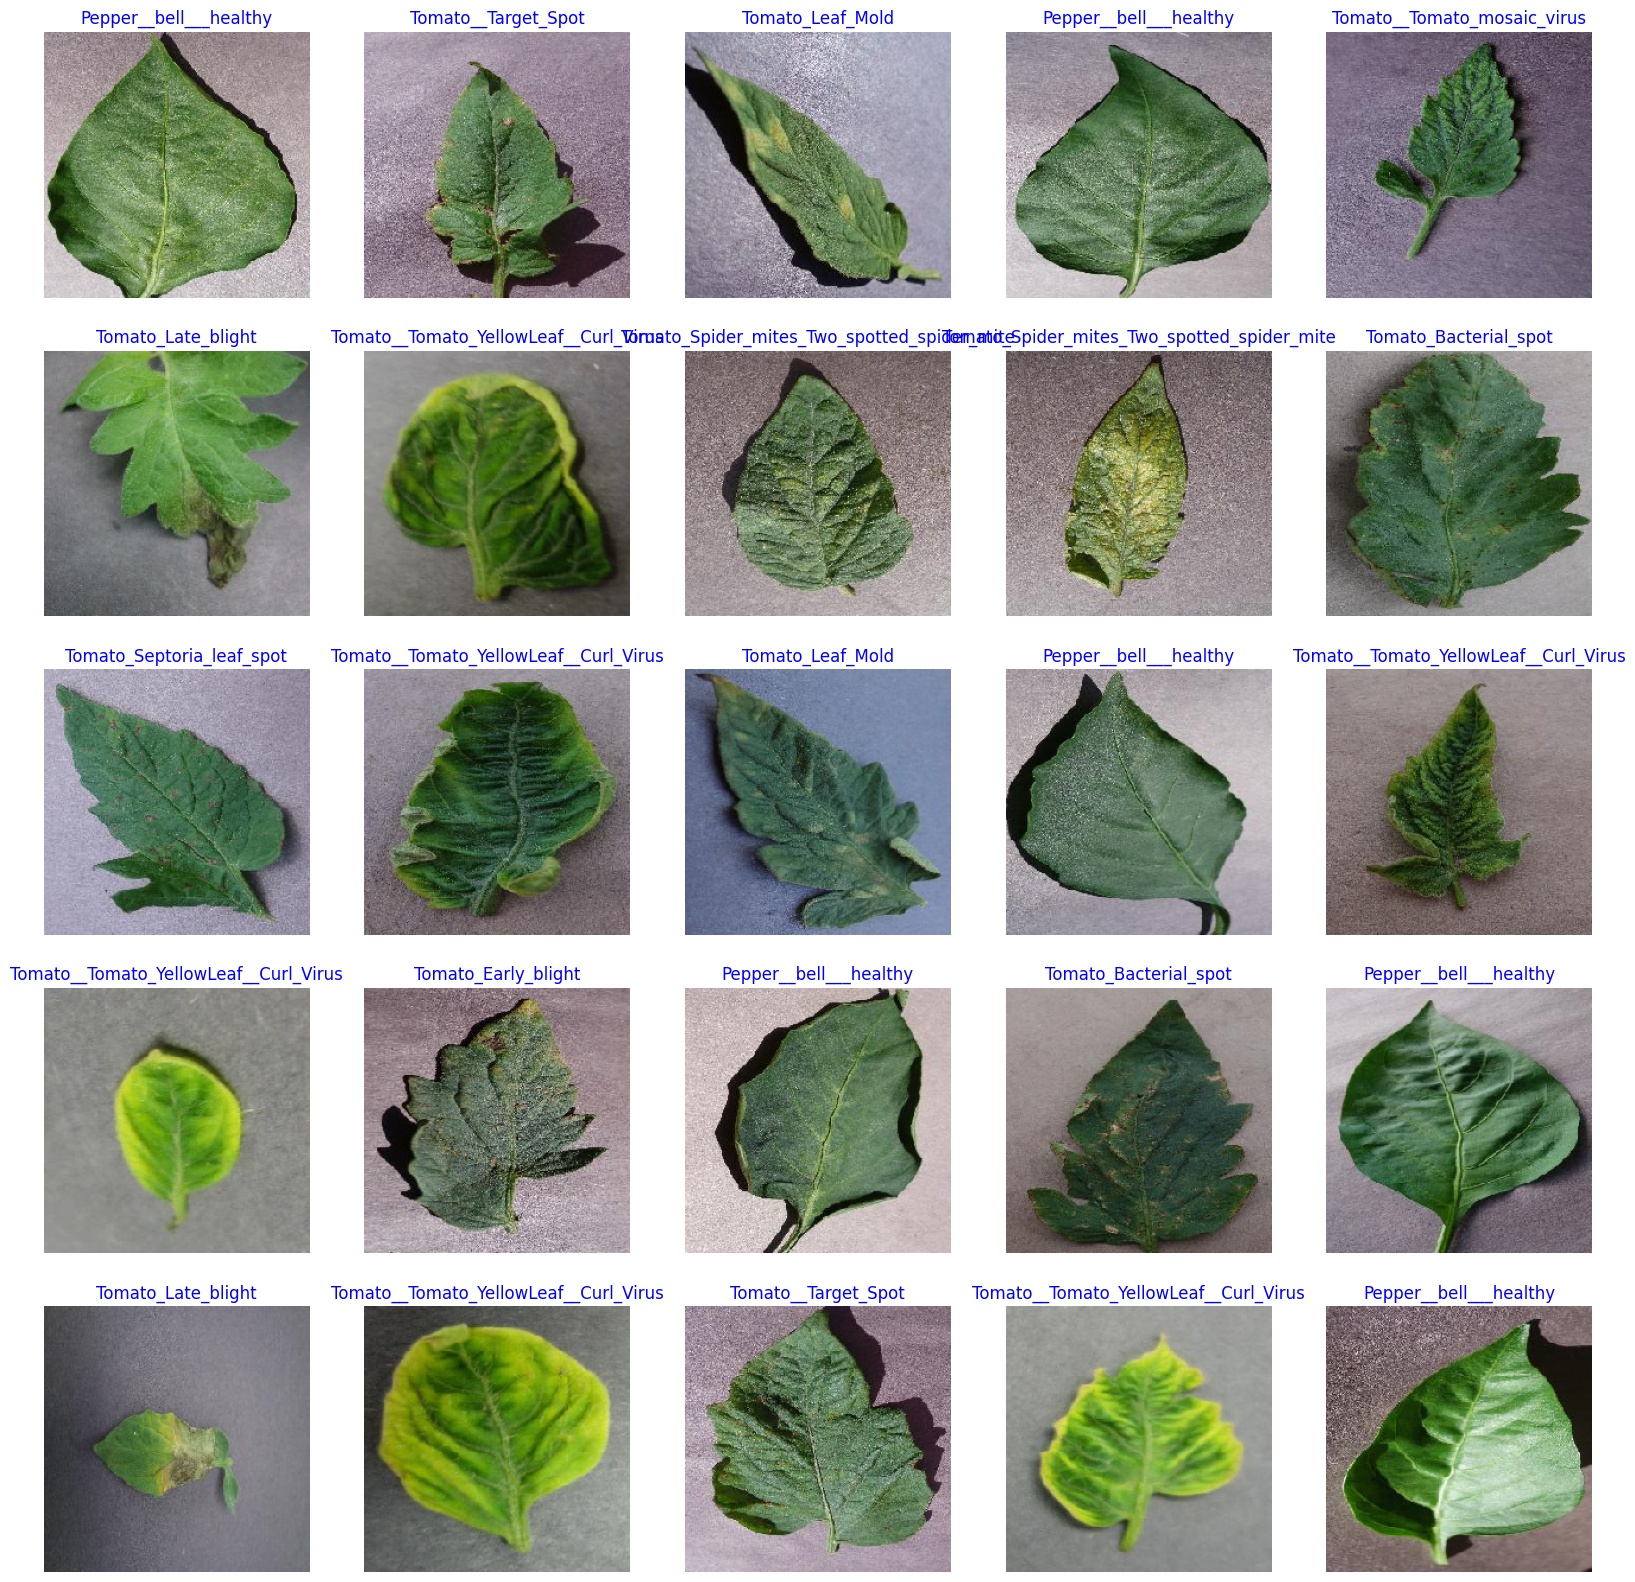

In [7]:
# I have already done step 1 with the seceret thing

#Step 2: Accessing and Exporting Kaggle secrets to the environment
from google.colab import userdata
import os
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

#Step 3: Download Dataset :
!kaggle datasets download -d emmarex/plantdisease
# !kaggle datasets download -d abdallahalidev/plantvillage-dataset

! mkdir data_sets
! unzip plantdisease.zip -d data_sets

# ! mkdir data_vin
# ! unzip plantvillage-dataset.zip -d data_vin


data_dir = '/content/data_sets/plantvillage/PlantVillage'
try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)
    show_images(train_gen)
except:
    print('Invalid Input')


# ***Implementing My Model***
This is my own modification of the MobileNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Add, AvgPool2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNet
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.optimizers import Adamax
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2



class_count = len(list(train_gen.class_indices.keys())) # Define number of classes in the dense layer


# Defining the my improved MobileNet block
def mobilenet_block(x, filters, kernel_size, strides):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)    # Apply Depthwise Convolution with specified kernel size and strides
    x = BatchNormalization()(x)                                                         # Apply Batch Normalization to the output of Depthwise Convolution
    x = ReLU()(x)                                                                       # Apply ReLU activation function

    x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)                    # Apply Pointwise Convolution with 1x1 kernel
    x = BatchNormalization()(x)                                                         # Apply Batch Normalization to the output of Pointwise Convolution
    x = ReLU()(x)                                                                       # Apply ReLU activation function

    return x

# Defining the stage function of MobileNet
def stage(x, filters, repetitions, strides):
    x = mobilenet_block(x, filters=filters, kernel_size=3, strides=strides)             # Apply the first MobileNet block with specified strides (for downsampling)
    for _ in range(repetitions - 1):                                                    # Apply the remaining MobileNet blocks with stride 1 (no downsampling)
        x = mobilenet_block(x, filters=filters, kernel_size=3, strides=1)
    return x

# Input shape
input_shape = (224, 224, 3)                                                             # Defines the input shape for the model (224x224 RGB image)
input_tensor = Input(shape=input_shape)                                                 # Create the input tensor

# Initial layers
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input_tensor)          # Apply initial Conv2D layer with 32 filters, 3x3 kernel, and stride 2 for downsampling
x = BatchNormalization()(x)                                                             # Apply Batch Normalization to the output of the Conv2D layer
x = ReLU()(x)                                                                           # Apply ReLU activation function
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)                                # Apply MaxPooling with 3x3 pool size and stride 2 for further downsampling

# Stages
repetitions = [3, 7, 3]                                                                 # Define the number of repetitions for each stage
filters = [64, 128, 256]                                                                # Define the number of filters for each stage
strides = [1, 2, 2]                                                                     # Define the strides for the first block of each stage (for downsampling)

# Apply each stage with the corresponding repetitions, filters, and strides
for reps, f, s in zip(repetitions, filters, strides):
    x = stage(x, filters=f, repetitions=reps, strides=s)

# Final layers
x = GlobalAveragePooling2D()(x)                                                                              # Apply Global Average Pooling to reduce the spatial dimensions to 1x1
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)                                     # Apply a Dense layer with 256 units and various regularizers
x = Dropout(rate=0.45, seed=123)(x)                                                                          # Apply Dropout with a rate of 0.45 for regularization
output_tensor = Dense(class_count, activation='softmax')(x)                                                  # Apply the final Dense layer with units equal to the number of classes and softmax activation

# Create model
model = Model(inputs=input_tensor, outputs=output_tensor)                               # Create the Keras model
model.summary()                                                                         # Print the model summary

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),                                    # Use Adamax optimizer with specified learning rate
              loss='categorical_crossentropy',                                          # Use categorical crossentropy loss
              metrics=['accuracy'])                                                     # Track accuracy as the metric


# Training parameters
batch_size = 40                                                                         # Set batch size for training
epochs = 40                                                                             # Number of epochs in training
patience = 1                                                                            # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3                                                                       # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9                                                                         # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5                                                                            # Factor to reduce learning rate by
ask_epoch = 5                                                                           # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))                              # Number of training batches to run per epoch

# Define callbacks (assuming MyCallback is defined elsewhere in your code)
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Fit the model
history = model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False)


# ***Evaluating my lighweight model's performance***

# New Model Evaluation performance and computational complexcities:
This Includes the following:
1. The parameter count
2. The Inferenece Time
3. The Memory usage
4. FLOPs
5. The actibvation count
I am keeping this one.

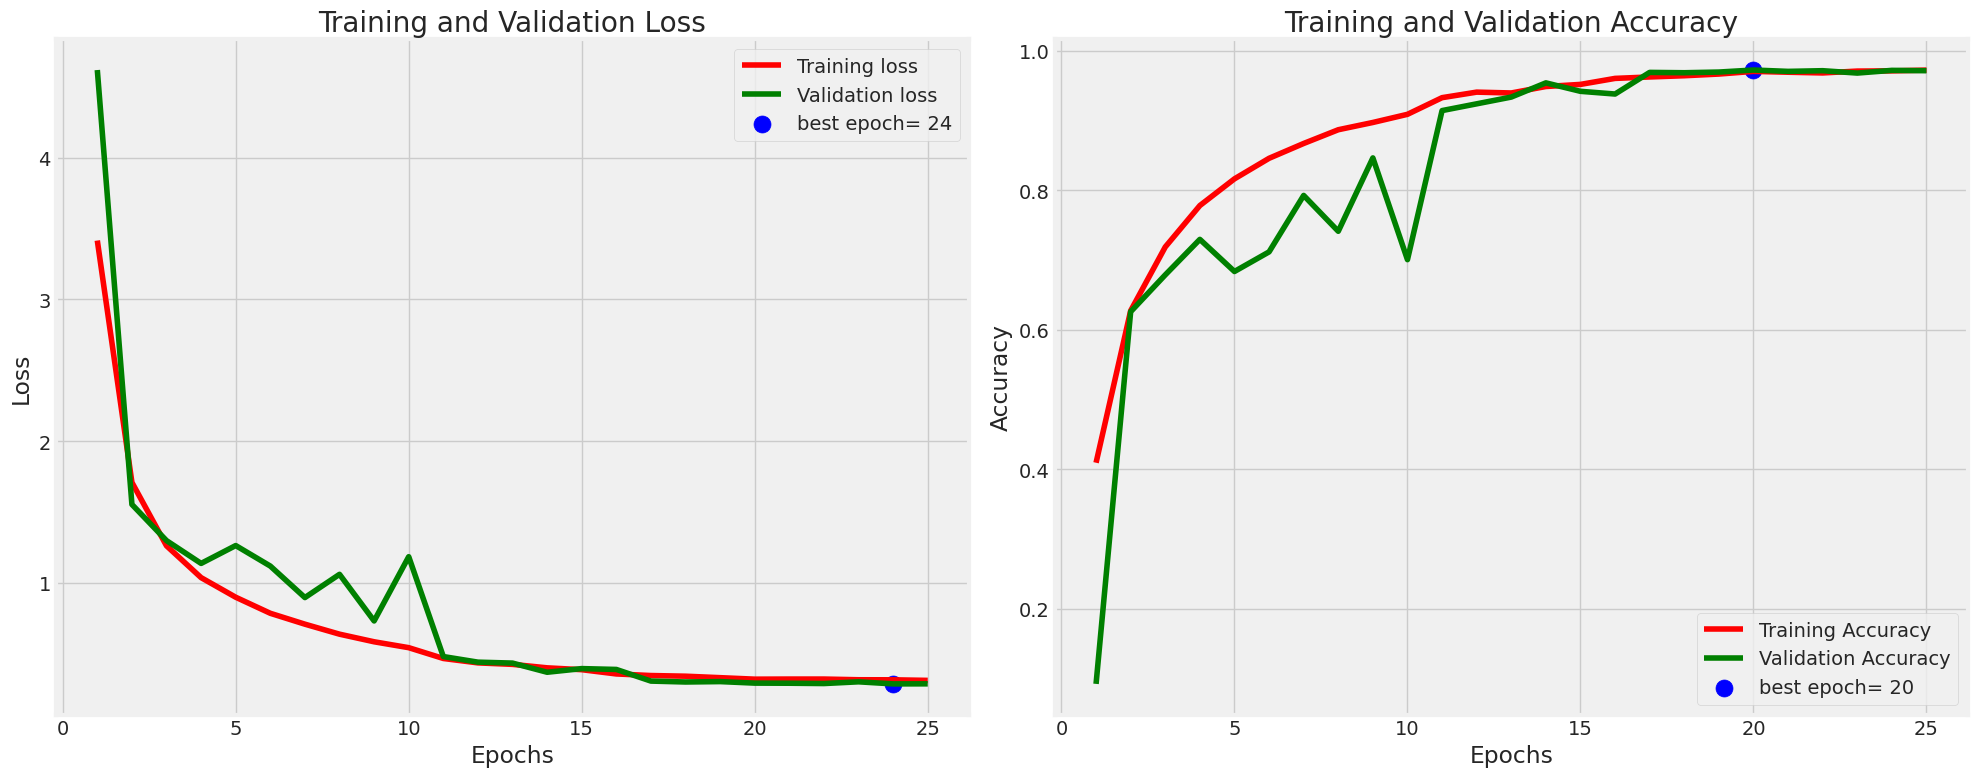

43/43 [==============================] - 5s 100ms/step - loss: 0.2774 - accuracy: 0.9782
Train Loss:  0.2349194437265396
Train Accuracy:  0.9918604493141174
--------------------
Validation Loss:  0.28631219267845154
Validation Accuracy:  0.9715116024017334
--------------------
Test Loss:  0.27742335200309753
Test Accuracy:  0.9781976938247681
Total number of parameters: 383375
Estimated memory usage: 1.46 MB
1/1 [==============================] - 1s 863ms/step
Inference time for a single input: 0.911014 seconds


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Total FLOPs: 0
Activation counts by layer:
input_1: (None, 224, 224, 3)
conv2d: (None, 112, 112, 32)
batch_normalization: (None, 112, 112, 32)
re_lu: (None, 112, 112, 32)
max_pooling2d: (None, 56, 56, 32)
depthwise_conv2d: (None, 56, 56, 32)
batch_normalization_1: (None, 56, 56, 32)
re_lu_1: (None, 56, 56, 32)
conv2d_1: (None, 56, 56, 64)
batch_normalization_2: (None, 56, 56, 64)
re_lu_2: (None, 56, 56, 64)
depthwise_conv2d_1: (None, 56, 56, 64)
batch_normalization_3: (None, 56, 56, 64)
re_lu_3: (None, 56, 56, 64)
conv2d_2: (None, 56, 56, 64)
batch_normalization_4: (None, 56, 56, 64)
re_lu_4: (None, 56, 56, 64)
depthwise_conv2d_2: (None, 56, 56, 64)
batch_normalization_5: (None, 56, 56, 64)
re_lu_5: (None, 56, 56, 64)
conv2d_3: (None, 56, 56, 64)
batch_normalization_6: (None, 56, 56, 64)
re_lu_6: (None, 56, 56, 64)
depthwise_conv2d_3: (None, 28, 28, 64)
batch_normalization_7: (None, 28, 28, 64)
re_lu_7: (None, 28, 28, 64)
conv2d_4: (None, 28, 28, 128)
batch_normalization_8: (None, 28, 

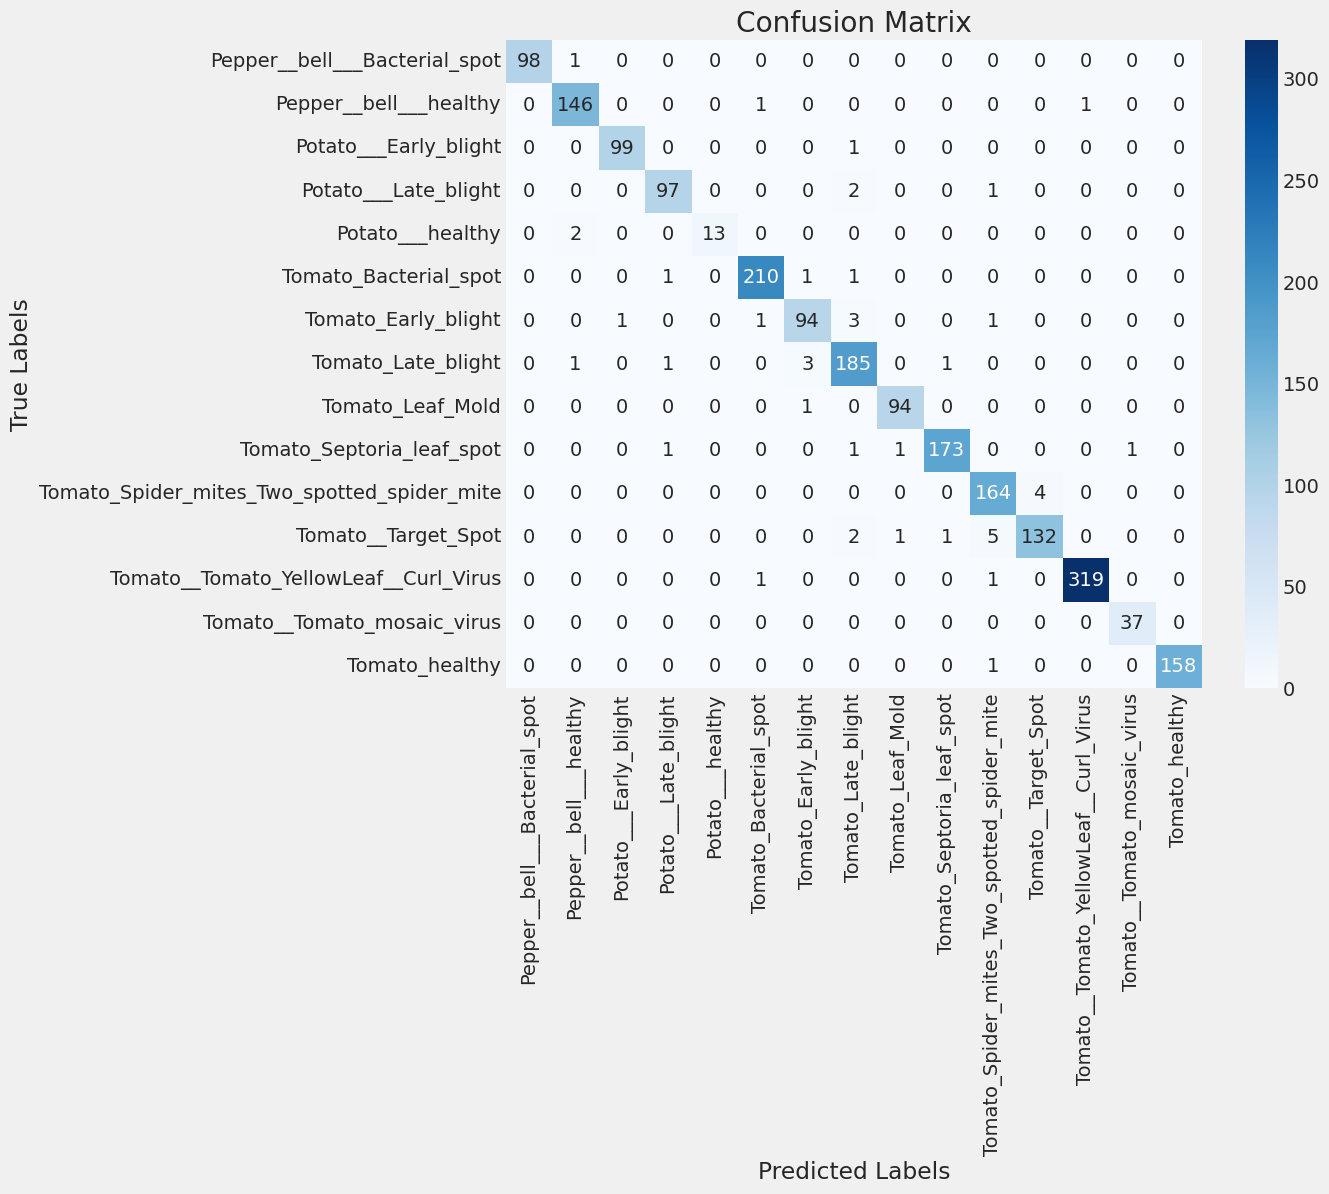

model was saved as i-Plant Village Disease-97.82.h5
weights were saved as i-Plant Village Disease-weights.h5
class csv file was saved as Plant Village Disease-class_dict.csv


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Plot training history
plot_training(history)

# Determine the test batch size that evenly divides the test dataset and is less than or equal to 80
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model on the training, validation, and test sets
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print the evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Additional Metrics Calculation
# Parameter Count
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

# Memory Usage
memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision, hence 4 bytes per parameter
print(f"Estimated memory usage: {memory_usage:.2f} MB")

# Inference Time
input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
start_time = time.time()
model.predict(input_data)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time for a single input: {inference_time:.6f} seconds")

# FLOPs Calculation
def get_flops(model):
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph
    with tf.Graph().as_default() as g:
        tf.import_graph_def(graph.as_graph_def(), name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

flops = get_flops(model)
print(f"Total FLOPs: {flops:,}")

# Activation Count
def get_activation_count(model):
    activations = {}
    for layer in model.layers:
        if hasattr(layer, 'output'):
            activations[layer.name] = layer.output.shape
    return activations

activation_counts = get_activation_count(model)
print("Activation counts by layer:")
for layer_name, shape in activation_counts.items():
    print(f"{layer_name}: {shape}")

# Calculate total activations, ignoring None shapes
total_activations = sum(np.prod(shape) for shape in activation_counts.values() if None not in shape)
print(f"Total number of activations: {total_activations:,}")

# Generate predictions using the test generator
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(preds, axis=1)  # Get the predicted class indices
print(y_pred)

# Get class indices from the test generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

# Construct the confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, y_pred)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Define model and save parameters
model_name = model.input_names[0][:-6]  # Extract model name by trimming the input layer suffix
subject = 'Plant Village Disease'
acc = test_score[1] * 100  # Convert accuracy to percentage
save_path = ''  # Define save path (empty for current directory)

# Save the trained model
save_id = str(f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save the model weights separately
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

# Generate class dictionary DataFrame
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = [img_size[0]] * len(class_dict)  # List of image heights
width = [img_size[1]] * len(class_dict)  # List of image widths

# Create Series for DataFrame
Index_series = pd.Series(list(class_dict.values()), name='class_index')
Class_series = pd.Series(list(class_dict.keys()), name='class')
Height_series = pd.Series(height, name='height')
Width_series = pd.Series(width, name='width')

# Concatenate Series into DataFrame
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)

# Save class dictionary DataFrame to CSV
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'class csv file was saved as {csv_save_loc}')


# ***Calculating activation for my Model***

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Add, AvgPool2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np
import time

def compute_metrics(model, input_shape):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(input_shape))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation using TensorFlow Profiler
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph_def = frozen_func.graph.as_graph_def()

        with tf.Graph().as_default() as graph:
            tf.compat.v1.import_graph_def(graph_def, name='')
            with tf.compat.v1.Session(graph=graph) as sess:
                run_meta = tf.compat.v1.RunMetadata()
                opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
                flops = tf.compat.v1.profiler.profile(graph=sess.graph, run_meta=run_meta, cmd='op', options=opts)
                return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        total_activations = 0
        for layer in model.layers:
            if hasattr(layer, 'output'):
                output_shape = layer.output.shape
                if output_shape is not None:
                    activations = np.prod(output_shape[1:])  # Skip the batch dimension
                    total_activations += activations
                    print(f"{layer.name}: {output_shape}, activations: {activations}")
        return total_activations

    total_activations = get_activation_count(model)
    print(f"Total activations: {total_activations}")

# Defining the model for MobileNet
class_count = len(list(train_gen.class_indices.keys())) # Define number of classes in the dense layer
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

def mobilenet_block(x, filters, kernel_size, strides):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def stage(x, filters, repetitions, strides):
    x = mobilenet_block(x, filters=filters, kernel_size=3, strides=strides)
    for _ in range(repetitions - 1):
        x = mobilenet_block(x, filters=filters, kernel_size=3, strides=1)
    return x

x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

repetitions = [3, 7, 3]
filters = [64, 128, 256]
strides = [1, 2, 2]

for reps, f, s in zip(repetitions, filters, strides):
    x = stage(x, filters=f, repetitions=reps, strides=s)

x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
output_tensor = Dense(class_count, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Run the compute_metrics function
compute_metrics(model, input_shape)


Total number of parameters: 383375
Estimated memory usage: 1.46 MB
1/1 [==============================] - 1s 637ms/step
Inference time for a single input: 0.676399 seconds
Total FLOPs: 0
input_2: (None, 224, 224, 3), activations: 150528
conv2d_14: (None, 112, 112, 32), activations: 401408
batch_normalization_27: (None, 112, 112, 32), activations: 401408
re_lu_27: (None, 112, 112, 32), activations: 401408
max_pooling2d_1: (None, 56, 56, 32), activations: 100352
depthwise_conv2d_13: (None, 56, 56, 32), activations: 100352
batch_normalization_28: (None, 56, 56, 32), activations: 100352
re_lu_28: (None, 56, 56, 32), activations: 100352
conv2d_15: (None, 56, 56, 64), activations: 200704
batch_normalization_29: (None, 56, 56, 64), activations: 200704
re_lu_29: (None, 56, 56, 64), activations: 200704
depthwise_conv2d_14: (None, 56, 56, 64), activations: 200704
batch_normalization_30: (None, 56, 56, 64), activations: 200704
re_lu_30: (None, 56, 56, 64), activations: 200704
conv2d_16: (None, 56

# ***calculating flops for my model***

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # Use TensorFlow v1.x API
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Dropout, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

def create_model(input_shape, class_count):
    # Input shape
    input_tensor = Input(shape=input_shape)  # Create the input tensor

    # Initial layers
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Stages
    def mobilenet_block(x, filters, kernel_size, strides):
        x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    def stage(x, filters, repetitions, strides):
        x = mobilenet_block(x, filters=filters, kernel_size=3, strides=strides)
        for _ in range(repetitions - 1):
            x = mobilenet_block(x, filters=filters, kernel_size=3, strides=1)
        return x

    repetitions = [3, 7, 3]
    filters = [64, 128, 256]
    strides = [1, 2, 2]

    for reps, f, s in zip(repetitions, filters, strides):
        x = stage(x, filters=f, repetitions=reps, strides=s)

    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=0.45, seed=123)(x)
    output_tensor = Dense(class_count, activation='softmax')(x)

    # Create model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Define input shape and class count
input_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))

# Create model within a session context
tf.reset_default_graph()
input_tensor = tf.placeholder(tf.float32, shape=(None,) + input_shape)
model = create_model(input_shape, class_count)
output_tensor = model(input_tensor)

# Calculate FLOPs and activations
graph = tf.get_default_graph()
with graph.as_default():
    inputs = tf.placeholder(tf.float32, shape=(None,) + input_shape)
    model(inputs)
    flops = tf.profiler.profile(graph, options=tf.profiler.ProfileOptionBuilder.float_operation())


# Print metrics
print(f"Total FLOPs: {flops.total_float_ops}")



Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.
192 ops no flops stats due to incomplete shapes.


Total FLOPs: 773445


# ***Comparing other mobileNet models***

# ***Implemetning MobileNet V_1***

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

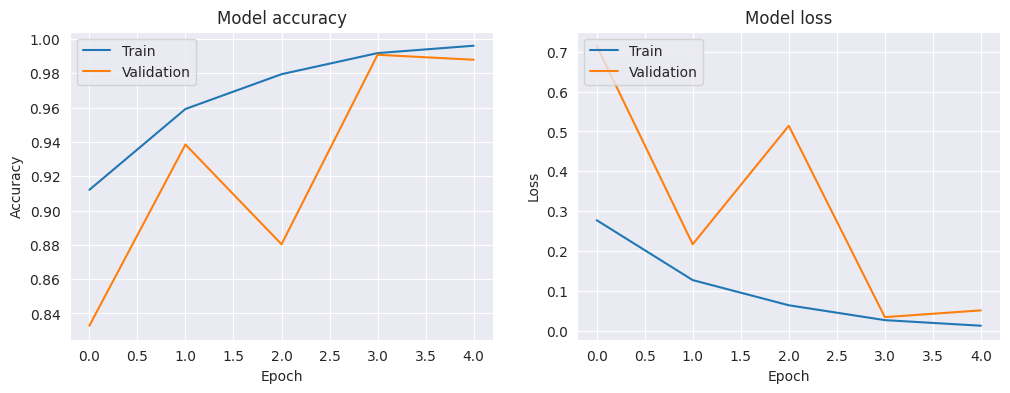

43/43 [==============================] - 5s 95ms/step - loss: 0.0326 - accuracy: 0.9889
Train Loss: 0.009920001029968262 Train Accuracy: 0.9964869618415833
Validation Loss: 0.03374045714735985 Validation Accuracy: 0.9907945990562439
Test Loss: 0.03255243971943855 Test Accuracy: 0.9888566136360168
43/43 [==============================] - 4s 81ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00        99
                     Pepper__bell___healthy       0.99      1.00      1.00       148
                      Potato___Early_blight       1.00      1.00      1.00       100
                       Potato___Late_blight       0.99      1.00      1.00       100
                           Potato___healthy       1.00      1.00      1.00        15
                      Tomato_Bacterial_spot       0.99      1.00      1.00       213
                        Tomat

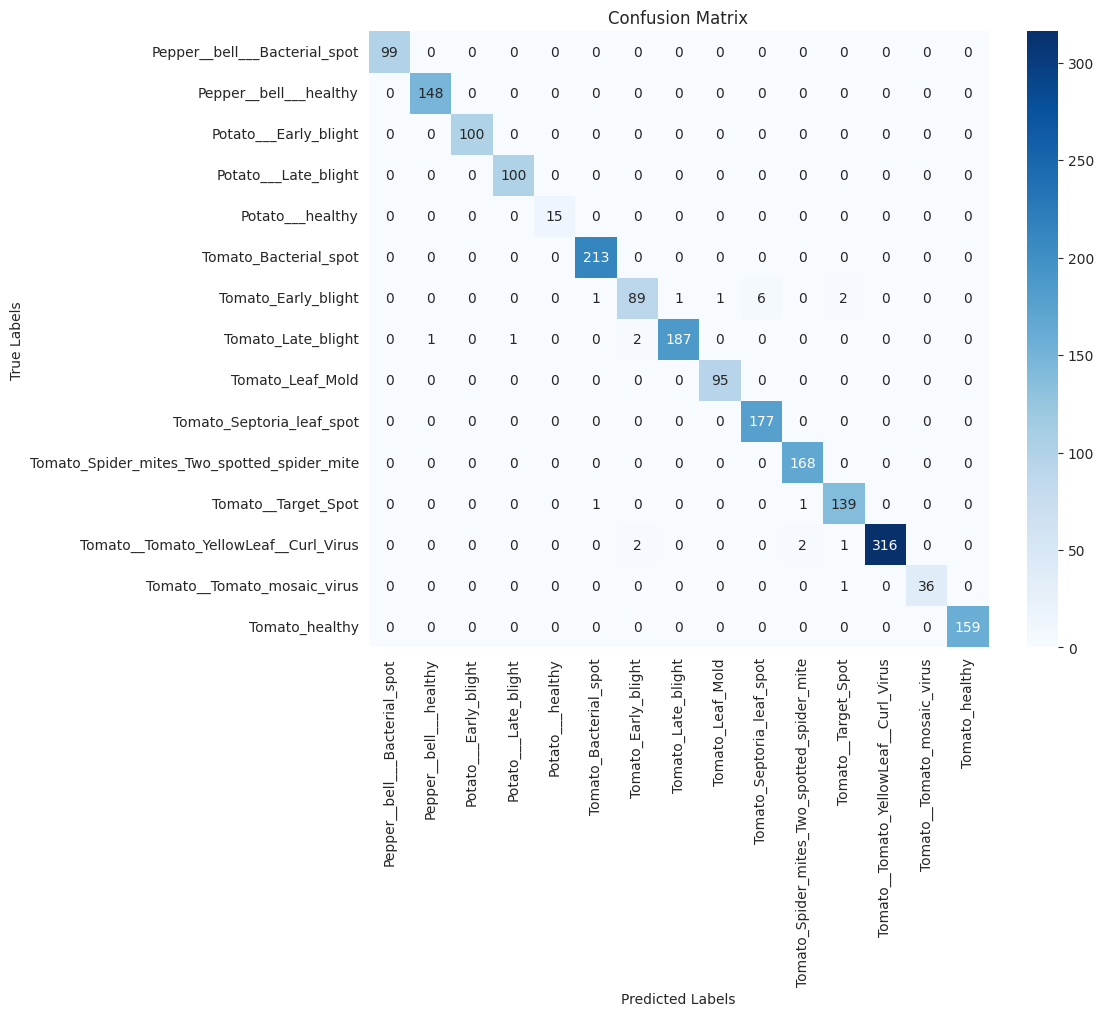

Total number of parameters: 3244239
Estimated memory usage: 12.38 MB
1/1 [==============================] - 1s 697ms/step
Inference time for a single input: 0.758443 seconds


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Total FLOPs: 0
Activation counts by layer:
input_1: (None, 224, 224, 3)
conv1: (None, 112, 112, 32)
conv1_bn: (None, 112, 112, 32)
conv1_relu: (None, 112, 112, 32)
conv_dw_1: (None, 112, 112, 32)
conv_dw_1_bn: (None, 112, 112, 32)
conv_dw_1_relu: (None, 112, 112, 32)
conv_pw_1: (None, 112, 112, 64)
conv_pw_1_bn: (None, 112, 112, 64)
conv_pw_1_relu: (None, 112, 112, 64)
conv_pad_2: (None, 113, 113, 64)
conv_dw_2: (None, 56, 56, 64)
conv_dw_2_bn: (None, 56, 56, 64)
conv_dw_2_relu: (None, 56, 56, 64)
conv_pw_2: (None, 56, 56, 128)
conv_pw_2_bn: (None, 56, 56, 128)
conv_pw_2_relu: (None, 56, 56, 128)
conv_dw_3: (None, 56, 56, 128)
conv_dw_3_bn: (None, 56, 56, 128)
conv_dw_3_relu: (None, 56, 56, 128)
conv_pw_3: (None, 56, 56, 128)
conv_pw_3_bn: (None, 56, 56, 128)
conv_pw_3_relu: (None, 56, 56, 128)
conv_pad_4: (None, 57, 57, 128)
conv_dw_4: (None, 28, 28, 128)
conv_dw_4_bn: (None, 28, 28, 128)
conv_dw_4_relu: (None, 28, 28, 128)
conv_pw_4: (None, 28, 28, 256)
conv_pw_4_bn: (None, 28, 28, 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming you have train_gen, valid_gen, and test_gen defined

# Input shape
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes

# Define MobileNet base model with pretrained ImageNet weights
base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model = Model(inputs=base_model.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Training parameters
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True)
# ]
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute metrics function
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

# Usage example for MobileNet with ImageNet weights
compute_metrics(model, test_gen)


# ***Calculating the FLOPs for MobileNet 1***

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import numpy as np

# Define input shape and number of classes
input_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))

def get_activation_count(model):
    total_activations = 0
    for layer in model.layers:
        if hasattr(layer, 'output'):
            output_shape = layer.output.shape
            if output_shape is not None:
                activations = np.prod(output_shape[1:])  # Skip the batch dimension
                total_activations += activations
                print(f"{layer.name}: {output_shape}, activations: {activations}")
    return total_activations

def create_model(input_shape, class_count):
    # Define MobileNet base model with pretrained ImageNet weights
    base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

    # Add additional layers for your specific task
    x = GlobalAveragePooling2D()(base_model.output)
    output_tensor = Dense(class_count, activation='softmax')(x)

    # Create your model
    model = Model(inputs=base_model.input, outputs=output_tensor)

    # Compile the model (adjust optimizer and loss as per your task)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create model
tf.compat.v1.disable_eager_execution()
with tf.compat.v1.Graph().as_default():
    input_tensor = tf.compat.v1.placeholder(tf.float32, shape=(None,) + input_shape)
    model = create_model(input_shape, class_count)
    output_tensor = model(input_tensor)

    # Calculate FLOPs and activations
    with tf.compat.v1.Session() as sess:
        run_metadata = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            tf.compat.v1.get_default_graph(),
            run_meta=run_metadata,
            cmd='op',
            options=opts)

        # Get activation count
        total_activations = get_activation_count(model)

# Print metrics
print(f"Total FLOPs: {flops.total_float_ops}")
print(f"Total activations: {total_activations}")

Instructions for updating:
Colocations handled automatically by placer.


input_1: (None, 224, 224, 3), activations: 150528
conv1: (None, 112, 112, 32), activations: 401408
conv1_bn: (None, 112, 112, 32), activations: 401408
conv1_relu: (None, 112, 112, 32), activations: 401408
conv_dw_1: (None, 112, 112, 32), activations: 401408
conv_dw_1_bn: (None, 112, 112, 32), activations: 401408
conv_dw_1_relu: (None, 112, 112, 32), activations: 401408
conv_pw_1: (None, 112, 112, 64), activations: 802816
conv_pw_1_bn: (None, 112, 112, 64), activations: 802816
conv_pw_1_relu: (None, 112, 112, 64), activations: 802816
conv_pad_2: (None, 113, 113, 64), activations: 817216
conv_dw_2: (None, 56, 56, 64), activations: 200704
conv_dw_2_bn: (None, 56, 56, 64), activations: 200704
conv_dw_2_relu: (None, 56, 56, 64), activations: 200704
conv_pw_2: (None, 56, 56, 128), activations: 401408
conv_pw_2_bn: (None, 56, 56, 128), activations: 401408
conv_pw_2_relu: (None, 56, 56, 128), activations: 401408
conv_dw_3: (None, 56, 56, 128), activations: 401408
conv_dw_3_bn: (None, 56, 56, 1

In [ ]:
import time
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np

# Function to compute various metrics for a given model
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params:,}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
        )
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

    # Calculate total activations, ignoring None shapes
    total_activations = sum(np.prod(shape) for shape in activation_counts.values() if None not in shape)
    print(f"Total number of activations: {total_activations:,}")

# Example usage
model = MobileNet()
# Assuming test_gen is defined elsewhere
# compute_metrics(model, test_gen)


# Usage example for MobileNet with ImageNet weights
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model_v1 = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))


compute_metrics(model_v1, test_gen)

17225924/17225924 [==============================] - 0s 0us/step
Total number of parameters: 3,228,864
Estimated memory usage: 12.32 MB


ValueError: When using data tensors as input to a model, you should specify the `steps` argument.

Try this for version 1. tomorrow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming you have train_gen, valid_gen, and test_gen defined

# Input shape
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes

# Define MobileNet base model with pretrained ImageNet weights
base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model = Model(inputs=base_model.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Training parameters
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True)
# ]
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute metrics function
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

# Usage example for MobileNet with ImageNet weights
compute_metrics(model, test_gen)


# ***Implementing MobileNet Version_2***

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

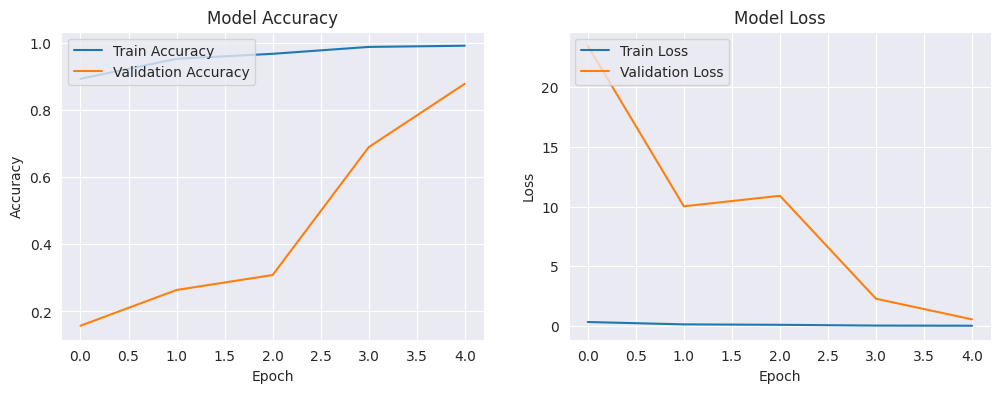

43/43 [==============================] - 6s 101ms/step - loss: 0.6786 - accuracy: 0.8682
Train Loss: 0.49956512451171875 Train Accuracy: 0.889582097530365
Validation Loss: 0.5546892881393433 Validation Accuracy: 0.8788759708404541
Test Loss: 0.6785769462585449 Test Accuracy: 0.8682170510292053
43/43 [==============================] - 5s 86ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.73      1.00      0.84        99
                     Pepper__bell___healthy       0.95      0.99      0.97       148
                      Potato___Early_blight       0.98      0.95      0.96       100
                       Potato___Late_blight       1.00      0.60      0.75       100
                           Potato___healthy       1.00      1.00      1.00        15
                      Tomato_Bacterial_spot       1.00      0.49      0.66       213
                        Tomato_E

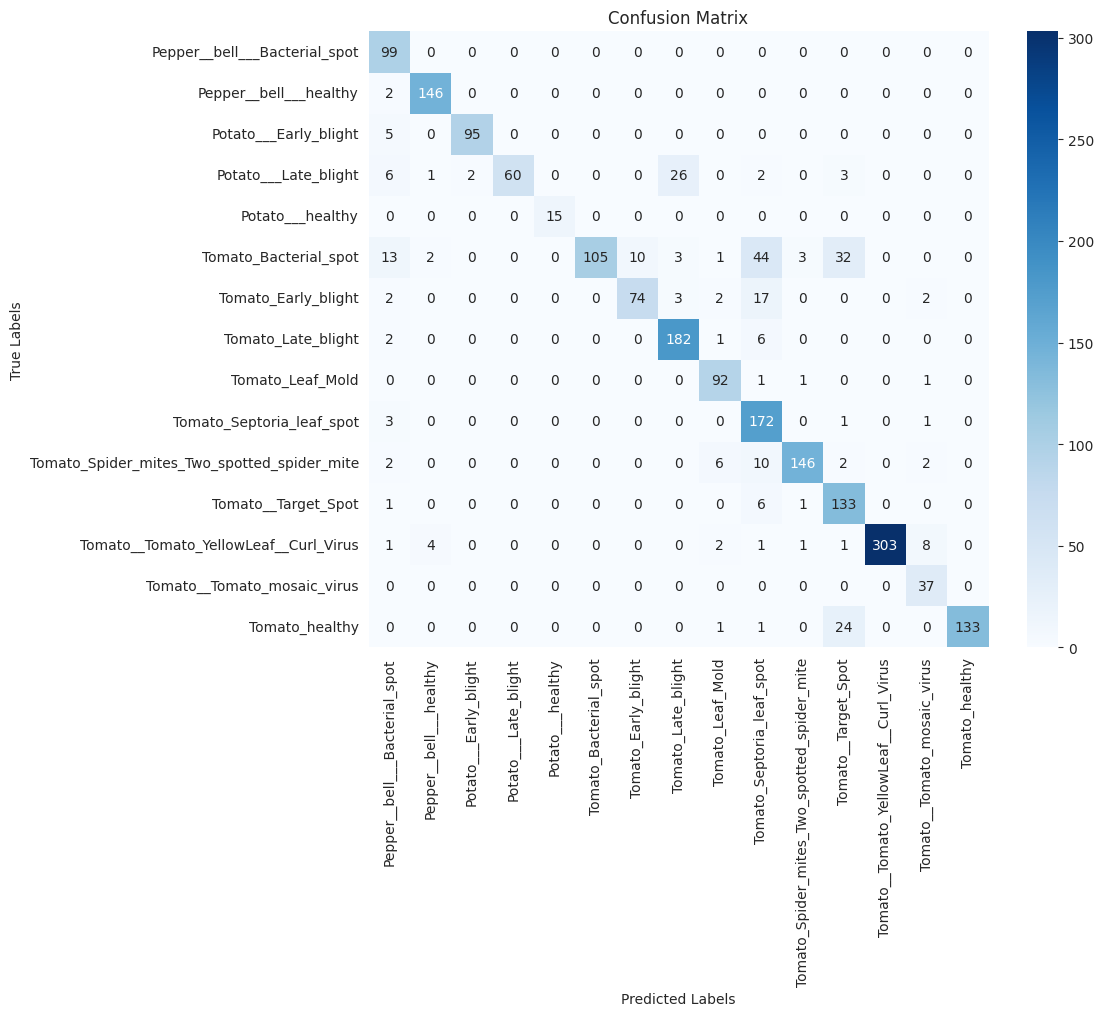

Total number of parameters: 2,277,199
Estimated memory usage: 8.69 MB
1/1 [==============================] - 1s 1s/step
Inference time for a single input: 1.361673 seconds


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Total FLOPs: 0
Activation counts by layer:
input_2: (None, 224, 224, 3)
Conv1: (None, 112, 112, 32)
bn_Conv1: (None, 112, 112, 32)
Conv1_relu: (None, 112, 112, 32)
expanded_conv_depthwise: (None, 112, 112, 32)
expanded_conv_depthwise_BN: (None, 112, 112, 32)
expanded_conv_depthwise_relu: (None, 112, 112, 32)
expanded_conv_project: (None, 112, 112, 16)
expanded_conv_project_BN: (None, 112, 112, 16)
block_1_expand: (None, 112, 112, 96)
block_1_expand_BN: (None, 112, 112, 96)
block_1_expand_relu: (None, 112, 112, 96)
block_1_pad: (None, 113, 113, 96)
block_1_depthwise: (None, 56, 56, 96)
block_1_depthwise_BN: (None, 56, 56, 96)
block_1_depthwise_relu: (None, 56, 56, 96)
block_1_project: (None, 56, 56, 24)
block_1_project_BN: (None, 56, 56, 24)
block_2_expand: (None, 56, 56, 144)
block_2_expand_BN: (None, 56, 56, 144)
block_2_expand_relu: (None, 56, 56, 144)
block_2_depthwise: (None, 56, 56, 144)
block_2_depthwise_BN: (None, 56, 56, 144)
block_2_depthwise_relu: (None, 56, 56, 144)
block_2_

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming train_gen, valid_gen, and test_gen are defined

# Configuration
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Define MobileNetV2 base model with pretrained ImageNet weights
base_model_v2 = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model_v2.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model_v2 = Model(inputs=base_model_v2.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_v2.summary()

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
callbacks = [MyCallback(model=model_v2, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history_v2 = model_v2.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score_v2 = model_v2.evaluate(train_gen)
valid_score_v2 = model_v2.evaluate(valid_gen)
test_score_v2 = model_v2.evaluate(test_gen)

print("Train Loss:", train_score_v2[0], "Train Accuracy:", train_score_v2[1])
print("Validation Loss:", valid_score_v2[0], "Validation Accuracy:", valid_score_v2[1])
print("Test Loss:", test_score_v2[0], "Test Accuracy:", test_score_v2[1])

# Generate predictions on test set
preds_v2 = model_v2.predict(test_gen)
y_pred_v2 = np.argmax(preds_v2, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_v2, target_names=class_labels))

conf_matrix_v2 = confusion_matrix(y_true, y_pred_v2)
print("Confusion Matrix:")
print(conf_matrix_v2)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_v2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Function to compute various metrics for a given model
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params:,}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
        )
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

    # Calculate total activations, ignoring None shapes
    total_activations = sum(np.prod(shape) for shape in activation_counts.values() if None not in shape)
    print(f"Total number of activations: {total_activations:,}")

# Usage example for MobileNetV2
compute_metrics(model_v2, test_gen)


# **mobileNet 2**


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

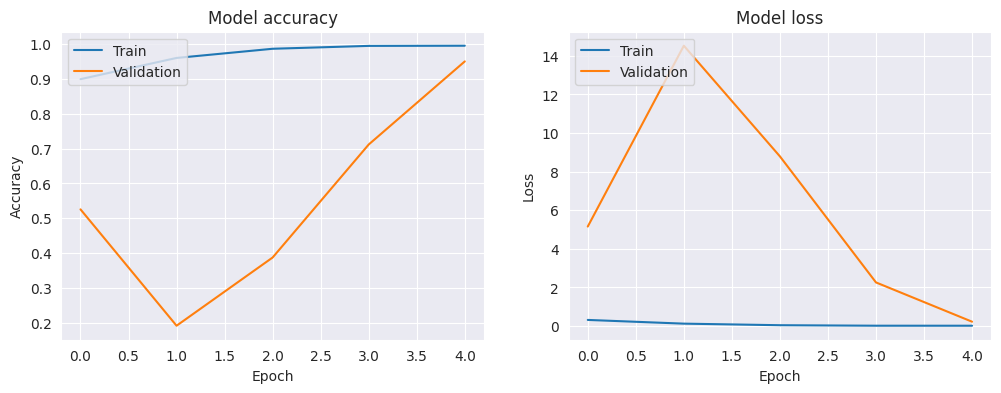

Train Loss: 0.13255862657152134 Train Accuracy: 0.9628104
Validation Loss: 0.22362649837920728 Validation Accuracy: 0.9500969
Test Loss: 0.2141706516619685 Test Accuracy: 0.94282943
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.85      1.00      0.92        99
                     Pepper__bell___healthy       0.99      0.98      0.99       148
                      Potato___Early_blight       0.96      1.00      0.98       100
                       Potato___Late_blight       1.00      0.92      0.96       100
                           Potato___healthy       1.00      0.93      0.97        15
                      Tomato_Bacterial_spot       0.99      0.96      0.97       213
                        Tomato_Early_blight       0.82      0.92      0.87       100
                         Tomato_Late_blight       0.97      0.97      0.97       191
                           To

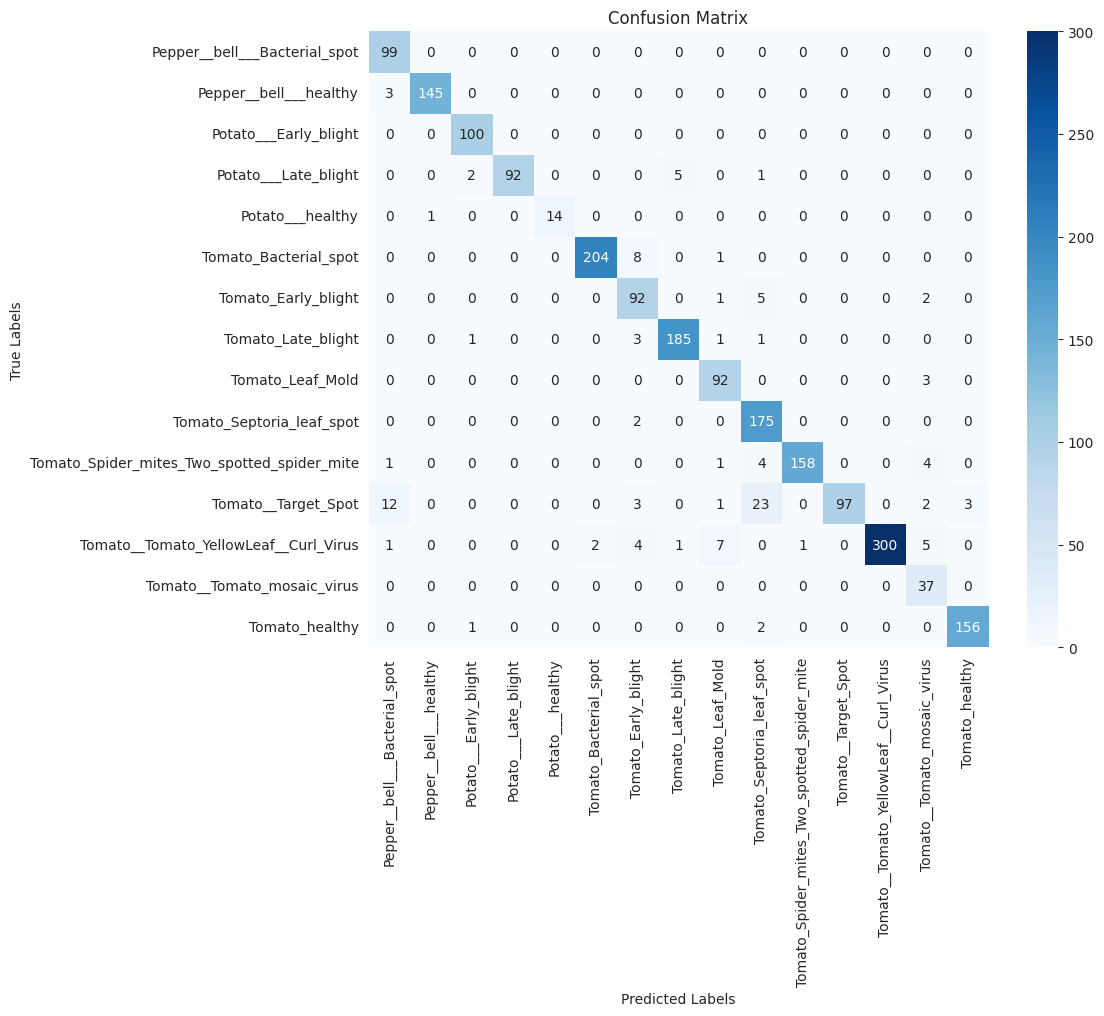

Total number of parameters: 2277199
Estimated memory usage: 8.69 MB


ValueError: When using data tensors as input to a model, you should specify the `steps` argument.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming you have train_gen, valid_gen, and test_gen defined

# Input shape
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes

# Define MobileNetV2 base model with pretrained ImageNet weights
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model = Model(inputs=base_model.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Training parameters
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True)
# ]
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen, steps=len(test_gen))  # Specify the number of steps
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute metrics

# Parameter Count
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

# Memory Usage
memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
print(f"Estimated memory usage: {memory_usage:.2f} MB")

# Inference Time
input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
start_time = time.time()
model.predict(input_data)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time for a single input: {inference_time:.6f} seconds")

# FLOPs Calculation
def get_flops(model):
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph
    with tf.Graph().as_default() as g:
        tf.import_graph_def(graph.as_graph_def(), name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

flops = get_flops(model)
print(f"Total FLOPs: {flops:,}")

# Activation Count
def get_activation_count(model):
    activations = {}
    for layer in model.layers:
        if hasattr(layer, 'output'):
            activations[layer.name] = layer.output.shape
    return activations

activation_counts = get_activation_count(model)
print("Activation counts by layer:")
for layer_name, shape in activation_counts.items():
    print(f"{layer_name}: {shape}")


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

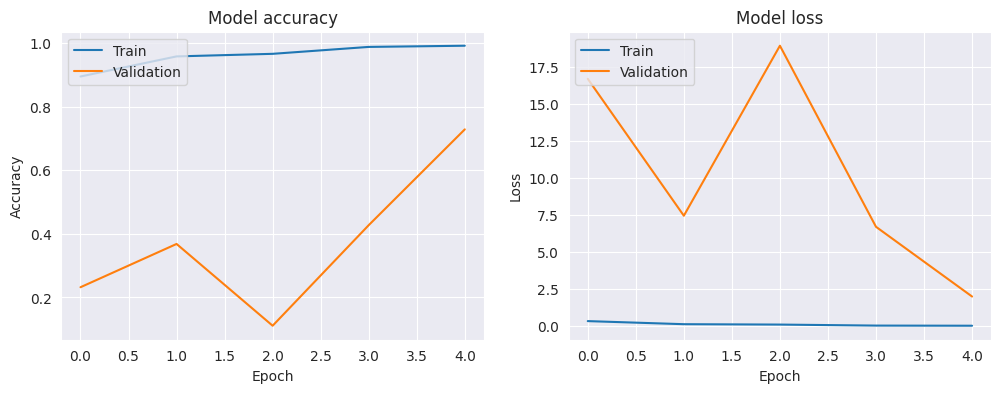

156/413 [==========>...................] - ETA: 22s - loss: 1.8865 - accuracy: 0.7327

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming you have train_gen, valid_gen, and test_gen defined

# Input shape
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes

# Define MobileNetV2 base model with pretrained ImageNet weights
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model = Model(inputs=base_model.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Training parameters
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True)
# ]
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen, steps=len(test_gen))  # Specify the number of steps
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute metrics

# Parameter Count
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

# Memory Usage
memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
print(f"Estimated memory usage: {memory_usage:.2f} MB")

# Inference Time
input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
start_time = time.time()
model(input_data)  # Using model directly for single input
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time for a single input: {inference_time:.6f} seconds")

# FLOPs Calculation
def get_flops(model):
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph
    with tf.Graph().as_default() as g:
        tf.import_graph_def(graph.as_graph_def(), name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

flops = get_flops(model)
print(f"Total FLOPs: {flops:,}")

# Activation Count
def get_activation_count(model):
    activations = {}
    for layer in model.layers:
        if hasattr(layer, 'output'):
            activations[layer.name] = layer.output.shape
    return activations

activation_counts = get_activation_count(model)
print("Activation counts by layer:")
for layer_name, shape in activation_counts.items():
    print(f"{layer_name}: {shape}")


In [ ]:

# Parameter Count
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

# Memory Usage
memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
print(f"Estimated memory usage: {memory_usage:.2f} MB")

# Inference Time
# input_data = tf.random.normal([1] + list(input_shape))  # Example input tensor
input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
start_time = time.time()
model(input_data)  # Using model directly for single input
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time for a single input: {inference_time:.6f} seconds")

# FLOPs Calculation
def get_flops(model):
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph
    with tf.Graph().as_default() as g:
        tf.import_graph_def(graph.as_graph_def(), name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

flops = get_flops(model)
print(f"Total FLOPs: {flops:,}")

# Activation Count
def get_activation_count(model):
    activations = {}
    for layer in model.layers:
        if hasattr(layer, 'output'):
            activations[layer.name] = layer.output.shape
    return activations

activation_counts = get_activation_count(model)
print("Activation counts by layer:")
for layer_name, shape in activation_counts.items():
    print(f"{layer_name}: {shape}")

Total number of parameters: 383375
Estimated memory usage: 1.46 MB
Inference time for a single input: 0.186399 seconds
Total FLOPs: 0
Activation counts by layer:
input_1: (None, 224, 224, 3)
conv2d: (None, 112, 112, 32)
batch_normalization: (None, 112, 112, 32)
re_lu: (None, 112, 112, 32)
max_pooling2d: (None, 56, 56, 32)
depthwise_conv2d: (None, 56, 56, 32)
batch_normalization_1: (None, 56, 56, 32)
re_lu_1: (None, 56, 56, 32)
conv2d_1: (None, 56, 56, 64)
batch_normalization_2: (None, 56, 56, 64)
re_lu_2: (None, 56, 56, 64)
depthwise_conv2d_1: (None, 56, 56, 64)
batch_normalization_3: (None, 56, 56, 64)
re_lu_3: (None, 56, 56, 64)
conv2d_2: (None, 56, 56, 64)
batch_normalization_4: (None, 56, 56, 64)
re_lu_4: (None, 56, 56, 64)
depthwise_conv2d_2: (None, 56, 56, 64)
batch_normalization_5: (None, 56, 56, 64)
re_lu_5: (None, 56, 56, 64)
conv2d_3: (None, 56, 56, 64)
batch_normalization_6: (None, 56, 56, 64)
re_lu_6: (None, 56, 56, 64)
depthwise_conv2d_3: (None, 28, 28, 64)
batch_normaliza

# ***calculating FLOPs and Activations for MobileNet version2***

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import numpy as np

# Define input shape and number of classes
input_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))

def get_activation_count(model):
    total_activations = 0
    for layer in model.layers:
        if hasattr(layer, 'output'):
            output_shape = layer.output.shape
            if output_shape is not None:
                activations = np.prod(output_shape[1:])  # Skip the batch dimension
                total_activations += activations
                print(f"{layer.name}: {output_shape}, activations: {activations}")
    return total_activations

def create_model(input_shape, class_count):
    # Define MobileNetV2 base model with pretrained ImageNet weights
    base_model_v2 = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Add additional layers for your specific task
    x = GlobalAveragePooling2D()(base_model_v2.output)
    output_tensor = Dense(class_count, activation='softmax')(x)

    # Create your model
    model_v2 = Model(inputs=base_model_v2.input, outputs=output_tensor)

    # Compile the model (adjust optimizer and loss as per your task)
    model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model_v2

# Create model
tf.compat.v1.disable_eager_execution()
with tf.compat.v1.Graph().as_default():
    input_tensor = tf.compat.v1.placeholder(tf.float32, shape=(None,) + input_shape)
    model_v2 = create_model(input_shape, class_count)
    output_tensor = model_v2(input_tensor)

    # Calculate FLOPs and activations
    with tf.compat.v1.Session() as sess:
        run_metadata = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            tf.compat.v1.get_default_graph(),
            run_meta=run_metadata,
            cmd='op',
            options=opts)

        # Get activation count
        total_activations = get_activation_count(model_v2)

# Print metrics
print(f"Total FLOPs: {flops.total_float_ops}")
print(f"Total activations: {total_activations}")

input_1: (None, 224, 224, 3), activations: 150528
Conv1: (None, 112, 112, 32), activations: 401408
bn_Conv1: (None, 112, 112, 32), activations: 401408
Conv1_relu: (None, 112, 112, 32), activations: 401408
expanded_conv_depthwise: (None, 112, 112, 32), activations: 401408
expanded_conv_depthwise_BN: (None, 112, 112, 32), activations: 401408
expanded_conv_depthwise_relu: (None, 112, 112, 32), activations: 401408
expanded_conv_project: (None, 112, 112, 16), activations: 200704
expanded_conv_project_BN: (None, 112, 112, 16), activations: 200704
block_1_expand: (None, 112, 112, 96), activations: 1204224
block_1_expand_BN: (None, 112, 112, 96), activations: 1204224
block_1_expand_relu: (None, 112, 112, 96), activations: 1204224
block_1_pad: (None, 113, 113, 96), activations: 1225824
block_1_depthwise: (None, 56, 56, 96), activations: 301056
block_1_depthwise_BN: (None, 56, 56, 96), activations: 301056
block_1_depthwise_relu: (None, 56, 56, 96), activations: 301056
block_1_project: (None, 56,

# ***Implementing mobileNet version_3***

12683000/12683000 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                 

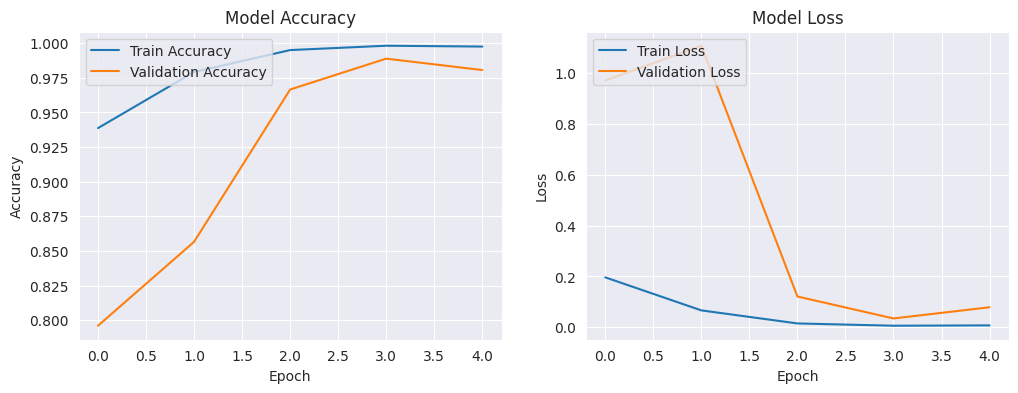

Train Loss: 0.008449898297157593 Train Accuracy: 0.9974561
Validation Loss: 0.03483545102244534 Validation Accuracy: 0.9888566
Test Loss: 0.030383502566194712 Test Accuracy: 0.9878876
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00        99
                     Pepper__bell___healthy       1.00      1.00      1.00       148
                      Potato___Early_blight       0.99      1.00      1.00       100
                       Potato___Late_blight       1.00      0.95      0.97       100
                           Potato___healthy       0.94      1.00      0.97        15
                      Tomato_Bacterial_spot       1.00      0.99      1.00       213
                        Tomato_Early_blight       1.00      0.94      0.97       100
                         Tomato_Late_blight       0.97      1.00      0.99       191
                           

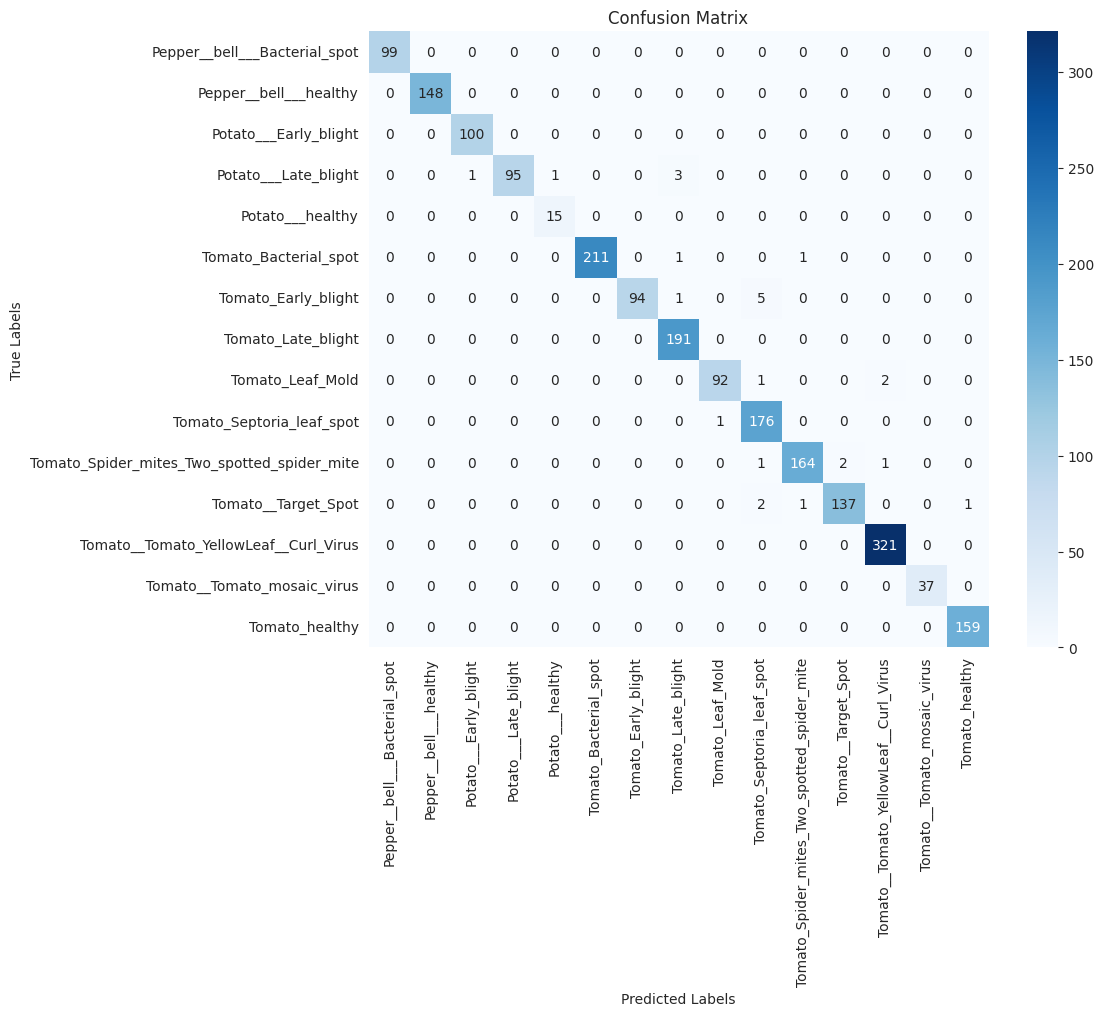

Total number of parameters: 3,010,767
Estimated memory usage: 11.49 MB


ValueError: When using data tensors as input to a model, you should specify the `steps` argument.

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming train_gen, valid_gen, and test_gen are defined

# Configuration
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Define MobileNetV3 base model with pretrained ImageNet weights
base_model_v3 = MobileNetV3Large(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model_v3.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model_v3 = Model(inputs=base_model_v3.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_v3.summary()

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
callbacks = [MyCallback(model=model_v3, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history_v3 = model_v3.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score_v3 = model_v3.evaluate(train_gen)
valid_score_v3 = model_v3.evaluate(valid_gen)
test_score_v3 = model_v3.evaluate(test_gen)

print("Train Loss:", train_score_v3[0], "Train Accuracy:", train_score_v3[1])
print("Validation Loss:", valid_score_v3[0], "Validation Accuracy:", valid_score_v3[1])
print("Test Loss:", test_score_v3[0], "Test Accuracy:", test_score_v3[1])

# Generate predictions on test set
preds_v3 = model_v3.predict(test_gen)
y_pred_v3 = np.argmax(preds_v3, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_v3, target_names=class_labels))

conf_matrix_v3 = confusion_matrix(y_true, y_pred_v3)
print("Confusion Matrix:")
print(conf_matrix_v3)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_v3, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Function to compute various metrics for a given model
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params:,}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
        )
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

    # Calculate total activations, ignoring None shapes
    total_activations = sum(np.prod(shape) for shape in activation_counts.values() if None not in shape)
    print(f"Total number of activations: {total_activations:,}")

# Usage example for MobileNetV3
compute_metrics(model_v3, test_gen)


# ***Calculating FLOPs and Activations for MobileNetV3Large***

In [ ]:

# Define input shape and number of classes
input_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))

def get_activation_count(model):
    total_activations = 0
    for layer in model.layers:
        if hasattr(layer, 'output'):
            output_shape = layer.output.shape
            if output_shape is not None:
                activations = np.prod(output_shape[1:])  # Skip the batch dimension
                total_activations += activations
                print(f"{layer.name}: {output_shape}, activations: {activations}")
    return total_activations

def create_model(input_shape, class_count):
    # Define MobileNetV3Large base model with pretrained ImageNet weights
    base_model_v3 = MobileNetV3Large(input_shape=input_shape, include_top=False, weights='imagenet')

    # Add additional layers for your specific task
    x = GlobalAveragePooling2D()(base_model_v3.output)
    output_tensor = Dense(class_count, activation='softmax')(x)

    # Create your model
    model_v3 = Model(inputs=base_model_v3.input, outputs=output_tensor)

    # Compile the model (adjust optimizer and loss as per your task)
    model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model_v3

# Create model
tf.compat.v1.disable_eager_execution()
with tf.compat.v1.Graph().as_default():
    input_tensor = tf.compat.v1.placeholder(tf.float32, shape=(None,) + input_shape)
    model_v3 = create_model(input_shape, class_count)
    output_tensor = model_v3(input_tensor)

    # Calculate FLOPs and activations
    with tf.compat.v1.Session() as sess:
        run_metadata = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            tf.compat.v1.get_default_graph(),
            run_meta=run_metadata,
            cmd='op',
            options=opts)

        # Get activation count
        total_activations = get_activation_count(model_v3)

# Print metrics
print(f"Total FLOPs: {flops.total_float_ops}")
print(f"Total activations: {total_activations}")

input_1: (None, 224, 224, 3), activations: 150528
rescaling: (None, 224, 224, 3), activations: 150528
Conv: (None, 112, 112, 16), activations: 200704
Conv/BatchNorm: (None, 112, 112, 16), activations: 200704
tf_op_layer_add: (None, 112, 112, 16), activations: 200704
re_lu: (None, 112, 112, 16), activations: 200704
tf_op_layer_mul: (None, 112, 112, 16), activations: 200704
multiply: (None, 112, 112, 16), activations: 200704
expanded_conv/depthwise: (None, 112, 112, 16), activations: 200704
expanded_conv/depthwise/BatchNorm: (None, 112, 112, 16), activations: 200704
re_lu_1: (None, 112, 112, 16), activations: 200704
expanded_conv/project: (None, 112, 112, 16), activations: 200704
expanded_conv/project/BatchNorm: (None, 112, 112, 16), activations: 200704
expanded_conv/Add: (None, 112, 112, 16), activations: 200704
expanded_conv_1/expand: (None, 112, 112, 64), activations: 802816
expanded_conv_1/expand/BatchNorm: (None, 112, 112, 64), activations: 802816
re_lu_2: (None, 112, 112, 64), acti

4334752/4334752 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                     

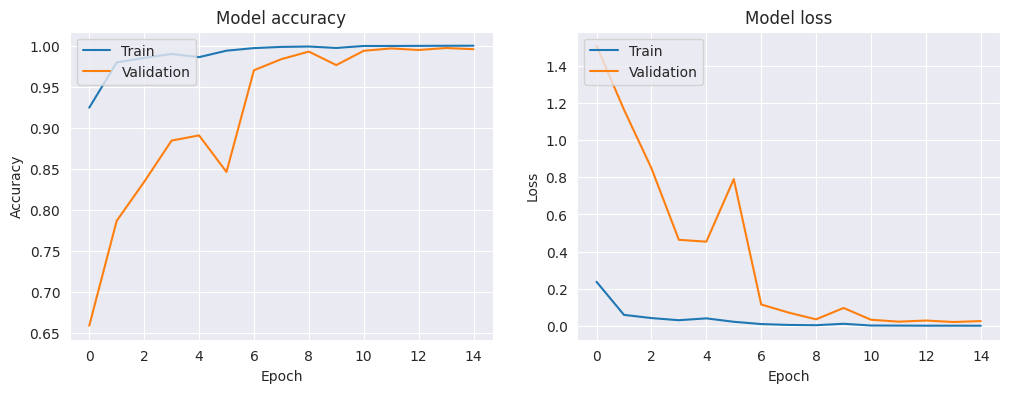

43/43 [==============================] - 4s 72ms/step - loss: 0.0083 - accuracy: 0.9976
Train Loss: 0.00013136840425431728 Train Accuracy: 0.9999394416809082
Validation Loss: 0.021002385765314102 Validation Accuracy: 0.9970930218696594
Test Loss: 0.008298580534756184 Test Accuracy: 0.9975775480270386
43/43 [==============================] - 5s 101ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00        99
                     Pepper__bell___healthy       1.00      1.00      1.00       148
                      Potato___Early_blight       1.00      1.00      1.00       100
                       Potato___Late_blight       1.00      0.99      0.99       100
                           Potato___healthy       1.00      1.00      1.00        15
                      Tomato_Bacterial_spot       1.00      1.00      1.00       213
                        

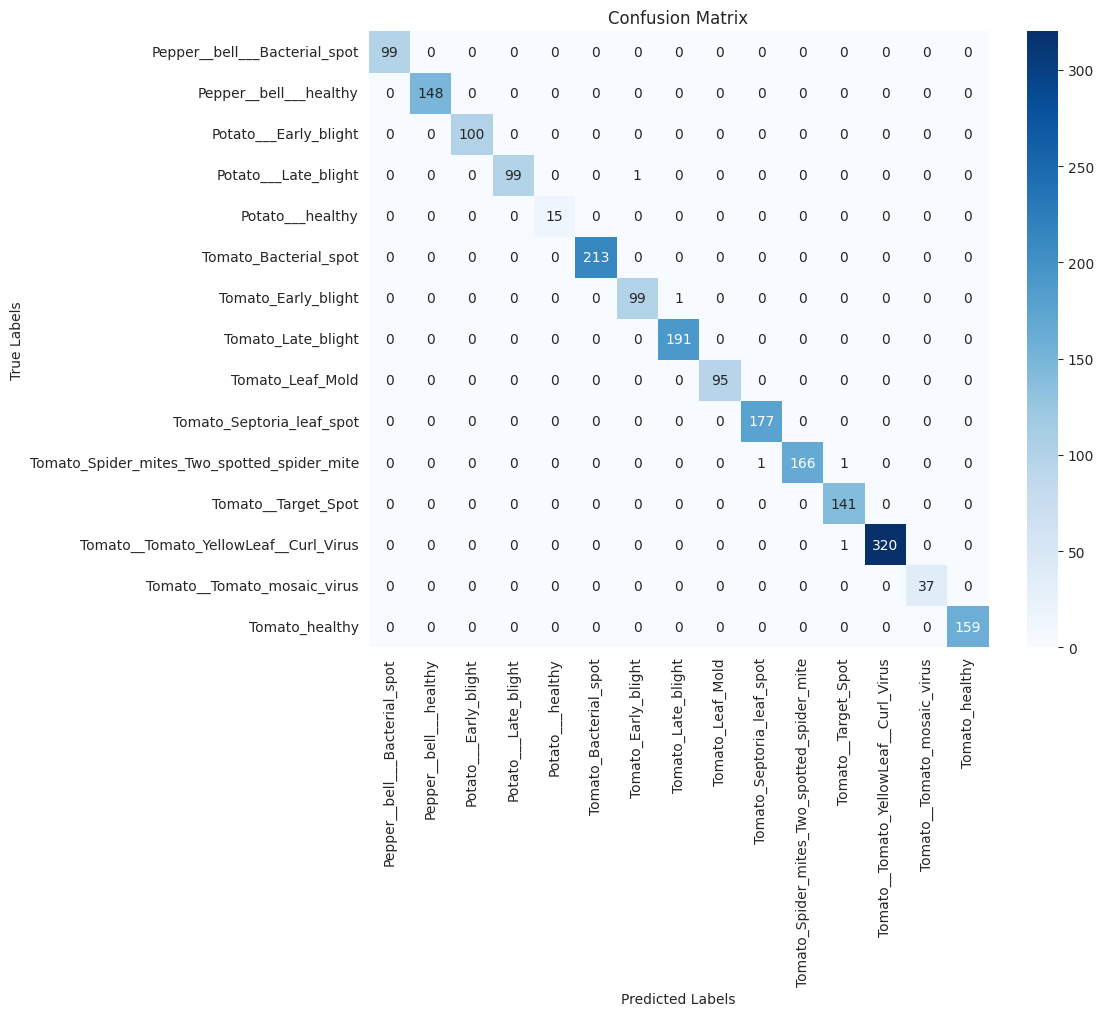

Total number of parameters: 947775
Estimated memory usage: 3.62 MB
1/1 [==============================] - 2s 2s/step
Inference time for a single input: 1.812190 seconds


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Total FLOPs: 0
Activation counts by layer:
input_1: (None, 224, 224, 3)
rescaling: (None, 224, 224, 3)
Conv: (None, 112, 112, 16)
Conv/BatchNorm: (None, 112, 112, 16)
tf.__operators__.add: (None, 112, 112, 16)
re_lu: (None, 112, 112, 16)
tf.math.multiply: (None, 112, 112, 16)
multiply: (None, 112, 112, 16)
expanded_conv/depthwise/pad: (None, 113, 113, 16)
expanded_conv/depthwise: (None, 56, 56, 16)
expanded_conv/depthwise/BatchNorm: (None, 56, 56, 16)
re_lu_1: (None, 56, 56, 16)
expanded_conv/squeeze_excite/AvgPool: (None, 1, 1, 16)
expanded_conv/squeeze_excite/Conv: (None, 1, 1, 8)
expanded_conv/squeeze_excite/Relu: (None, 1, 1, 8)
expanded_conv/squeeze_excite/Conv_1: (None, 1, 1, 16)
tf.__operators__.add_1: (None, 1, 1, 16)
re_lu_2: (None, 1, 1, 16)
tf.math.multiply_1: (None, 1, 1, 16)
expanded_conv/squeeze_excite/Mul: (None, 56, 56, 16)
expanded_conv/project: (None, 56, 56, 16)
expanded_conv/project/BatchNorm: (None, 56, 56, 16)
expanded_conv_1/expand: (None, 56, 56, 72)
expanded_co

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming you have train_gen, valid_gen, and test_gen defined

# Input shape
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes

# Define MobileNetV3Small base model with pretrained ImageNet weights
base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model = Model(inputs=base_model.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Training parameters
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True)
# ]
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute metrics function
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

# Usage example for MobileNetV3Small with ImageNet weights
compute_metrics(model, test_gen)


# ***Calculating FLOPs and activation for MobileNetV3Small model***

In [10]:
import tensorflow as tf

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2


# Define input shape and number of classes
input_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))

def get_activation_count(model):
    total_activations = 0
    for layer in model.layers:
        if hasattr(layer, 'output'):
            output_shape = layer.output.shape
            if output_shape is not None:
                activations = np.prod(output_shape[1:])  # Skip the batch dimension
                total_activations += activations
                print(f"{layer.name}: {output_shape}, activations: {activations}")
    return total_activations

def create_model(input_shape, class_count):
    # Define MobileNetV3Small base model with pretrained ImageNet weights
    base_model_v3 = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')

    # Add additional layers for your specific task
    x = GlobalAveragePooling2D()(base_model_v3.output)
    output_tensor = Dense(class_count, activation='softmax')(x)

    # Create your model
    model_v3 = Model(inputs=base_model_v3.input, outputs=output_tensor)

    # Compile the model (adjust optimizer and loss as per your task)
    model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model_v3

# Create model
tf.compat.v1.disable_eager_execution()
with tf.compat.v1.Graph().as_default():
    input_tensor = tf.compat.v1.placeholder(tf.float32, shape=(None,) + input_shape)
    model_v3 = create_model(input_shape, class_count)
    output_tensor = model_v3(input_tensor)

    # Calculate FLOPs and activations
    with tf.compat.v1.Session() as sess:
        run_metadata = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            tf.compat.v1.get_default_graph(),
            run_meta=run_metadata,
            cmd='op',
            options=opts)

        # Get activation count
        total_activations = get_activation_count(model_v3)

# Print metrics
print(f"Total FLOPs: {flops.total_float_ops}")
print(f"Total activations: {total_activations}")

Instructions for updating:
Colocations handled automatically by placer.


input_1: (None, 224, 224, 3), activations: 150528
rescaling: (None, 224, 224, 3), activations: 150528
Conv: (None, 112, 112, 16), activations: 200704
Conv/BatchNorm: (None, 112, 112, 16), activations: 200704
tf_op_layer_add: (None, 112, 112, 16), activations: 200704
re_lu: (None, 112, 112, 16), activations: 200704
tf_op_layer_mul: (None, 112, 112, 16), activations: 200704
multiply: (None, 112, 112, 16), activations: 200704
expanded_conv/depthwise/pad: (None, 113, 113, 16), activations: 204304
expanded_conv/depthwise: (None, 56, 56, 16), activations: 50176
expanded_conv/depthwise/BatchNorm: (None, 56, 56, 16), activations: 50176
re_lu_1: (None, 56, 56, 16), activations: 50176
expanded_conv/squeeze_excite/AvgPool: (None, 1, 1, 16), activations: 16
expanded_conv/squeeze_excite/Conv: (None, 1, 1, 8), activations: 8
expanded_conv/squeeze_excite/Relu: (None, 1, 1, 8), activations: 8
expanded_conv/squeeze_excite/Conv_1: (None, 1, 1, 16), activations: 16
tf_op_layer_add_1: (None, 1, 1, 16), ac

# ***Ablation Study 1: Removing Batch Normalization Layers***

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
413/413 [==============================] - 49s 101ms/step - loss: 3.0007 - accuracy: 0.1549 - val_loss: 2.6099 - val_accuracy: 0.1555
Epoch 2/40
413/413 [==============================] - 40s 96ms/step - loss: 2.6085 - accuracy: 0.1554 - val_loss: 2.5990 - val_accuracy: 0.1555
Epoch 3/40
413/413 [==============================] - 43s 103ms/step - loss: 2.5992 - accuracy: 0.1554 - val_loss: 2.5933 - val_accuracy: 0.1555
Epoch 4/40
413/413 [==============================] - 40s 97ms/step - loss: 2.5944 - accuracy: 0.1554 - val_loss: 2.5906 - val_accuracy: 0.1555
Epoch 5/40
413/413 [==============================] - ETA: 0s - loss: 2.5931 - accuracy: 0.1554 5 /40     2.593   15.542   2.58952  15.552   0.00025  0.00013  accuracy     0.00    39.91  
 training has been halted at epoch 5 after 3 adjustments of learning rate with no im

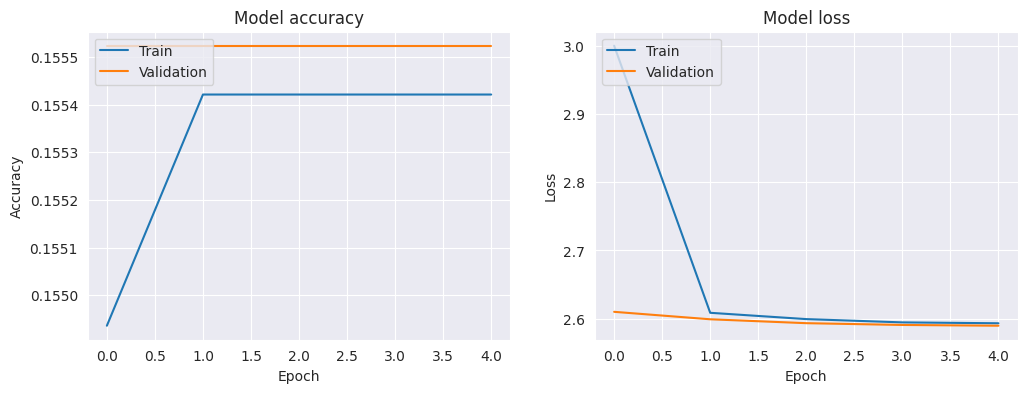

43/43 [==============================] - 4s 98ms/step - loss: 2.5982 - accuracy: 0.1555
Train Loss: 2.5988879203796387 Train Accuracy: 0.1554209589958191
Validation Loss: 2.5989744663238525 Validation Accuracy: 0.15552325546741486
Test Loss: 2.5982463359832764 Test Accuracy: 0.15552325546741486
43/43 [==============================] - 4s 86ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00        99
                     Pepper__bell___healthy       0.00      0.00      0.00       148
                      Potato___Early_blight       0.00      0.00      0.00       100
                       Potato___Late_blight       0.00      0.00      0.00       100
                           Potato___healthy       0.00      0.00      0.00        15
                      Tomato_Bacterial_spot       0.00      0.00      0.00       213
                        Tomato_

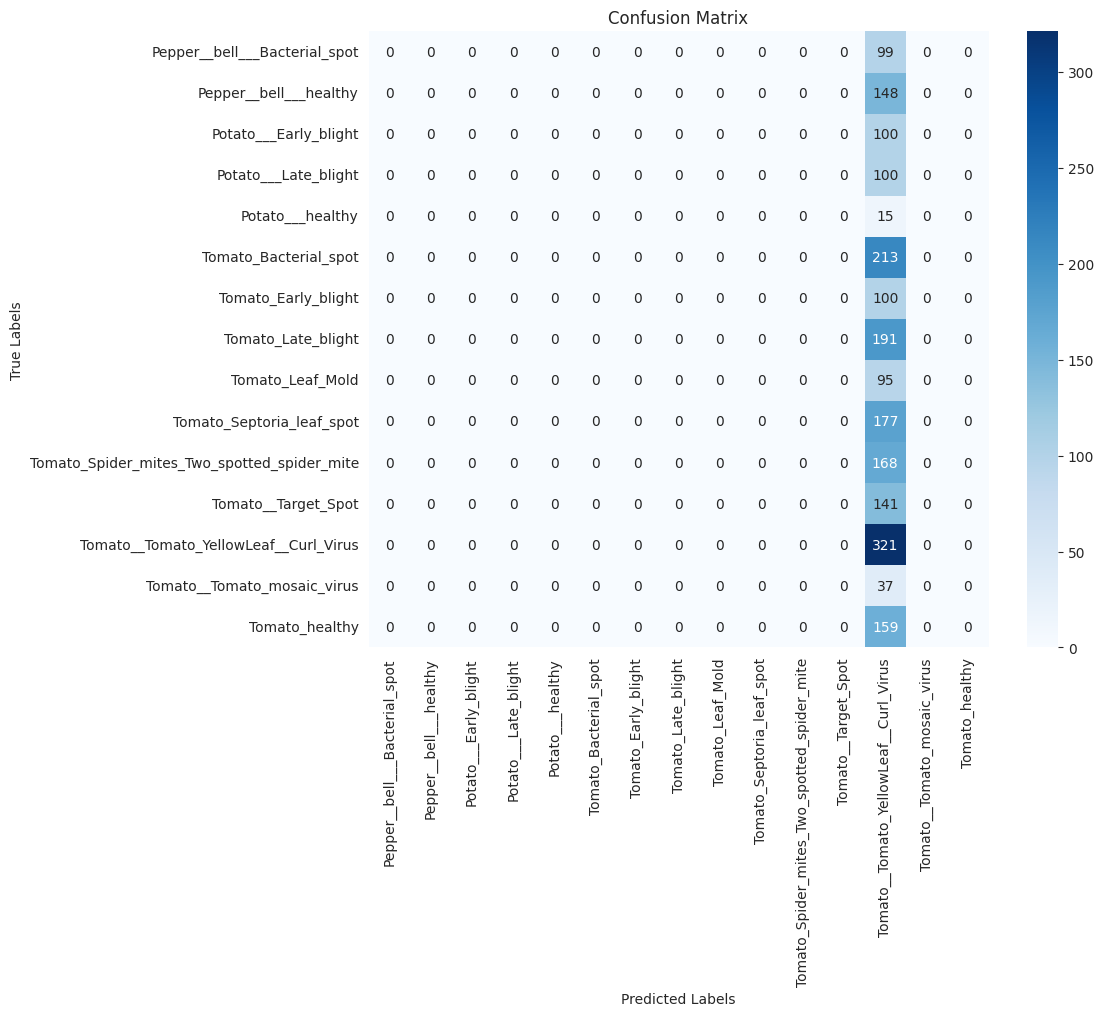

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Dropout, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
import numpy as np

# Function to create the model without BatchNormalization layers
def create_model_without_batchnorm(input_shape, class_count):
    input_tensor = Input(shape=input_shape)

    # Initial layers
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input_tensor)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Define MobileNet block without BatchNormalization
    def mobilenet_block(x, filters, kernel_size, strides):
        x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
        x = ReLU()(x)
        return x

    # Function to create a stage of MobileNet without BatchNormalization
    def stage(x, filters, repetitions, strides):
        x = mobilenet_block(x, filters=filters, kernel_size=3, strides=strides)
        for _ in range(repetitions - 1):
            x = mobilenet_block(x, filters=filters, kernel_size=3, strides=1)
        return x

    # Define the number of repetitions, filters, and strides for each stage
    repetitions = [3, 7, 3]
    filters = [64, 128, 256]
    strides = [1, 2, 2]

    # Build the model architecture without BatchNormalization layers
    for reps, f, s in zip(repetitions, filters, strides):
        x = stage(x, filters=f, repetitions=reps, strides=s)

    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=0.45, seed=123)(x)
    output_tensor = Dense(class_count, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Example usage
input_shape = (224, 224, 3)  # Define input shape based on your dataset
class_count = len(train_gen.class_indices)  # Number of classes
model = create_model_without_batchnorm(input_shape, class_count)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training parameters
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# ***Ablation Study 2: Removing Dropout Layers***

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
413/413 [==============================] - 54s 102ms/step - loss: 3.1361 - accuracy: 0.4475 - val_loss: 4.3241 - val_accuracy: 0.1555
Epoch 2/40
413/413 [==============================] - 44s 107ms/step - loss: 1.4837 - accuracy: 0.6776 - val_loss: 1.3030 - val_accuracy: 0.6991
Epoch 3/40
413/413 [==============================] - 44s 107ms/step - loss: 1.1174 - accuracy: 0.7514 - val_loss: 1.4000 - val_accuracy: 0.6308
Epoch 4/40
413/413 [==============================] - 43s 104ms/step - loss: 0.9205 - accuracy: 0.8035 - val_loss: 1.2578 - val_accuracy: 0.6710
Epoch 5/40
413/413 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.8362 5 /40     0.789   83.622   0.90766  78.585   0.00100  0.00100  accuracy     4.07    41.53  
enter H to halt training or an integer for number of epochs to run then ask again


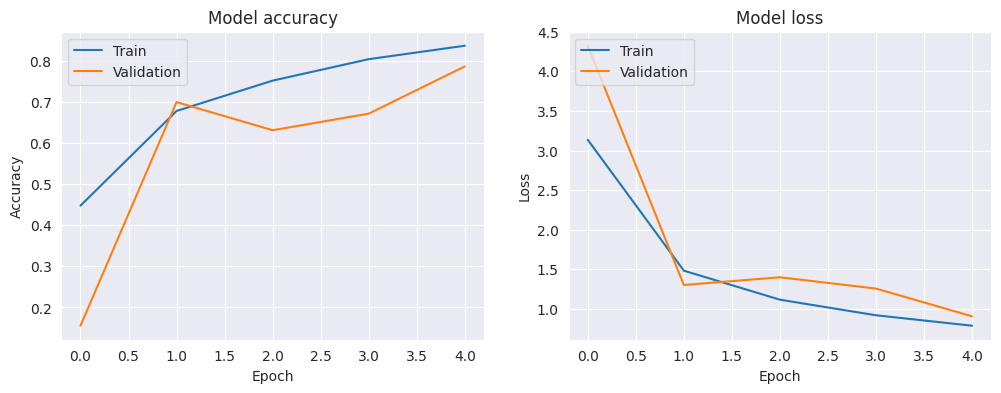

43/43 [==============================] - 7s 160ms/step - loss: 0.9248 - accuracy: 0.7849
Train Loss: 0.8977347016334534 Train Accuracy: 0.7940642237663269
Validation Loss: 0.9076608419418335 Validation Accuracy: 0.7858527302742004
Test Loss: 0.9248313307762146 Test Accuracy: 0.7848837375640869
43/43 [==============================] - 4s 79ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.57      0.71        99
                     Pepper__bell___healthy       0.83      0.83      0.83       148
                      Potato___Early_blight       0.86      0.89      0.87       100
                       Potato___Late_blight       0.79      0.64      0.71       100
                           Potato___healthy       0.00      0.00      0.00        15
                      Tomato_Bacterial_spot       0.90      0.93      0.92       213
                        Tomato_E

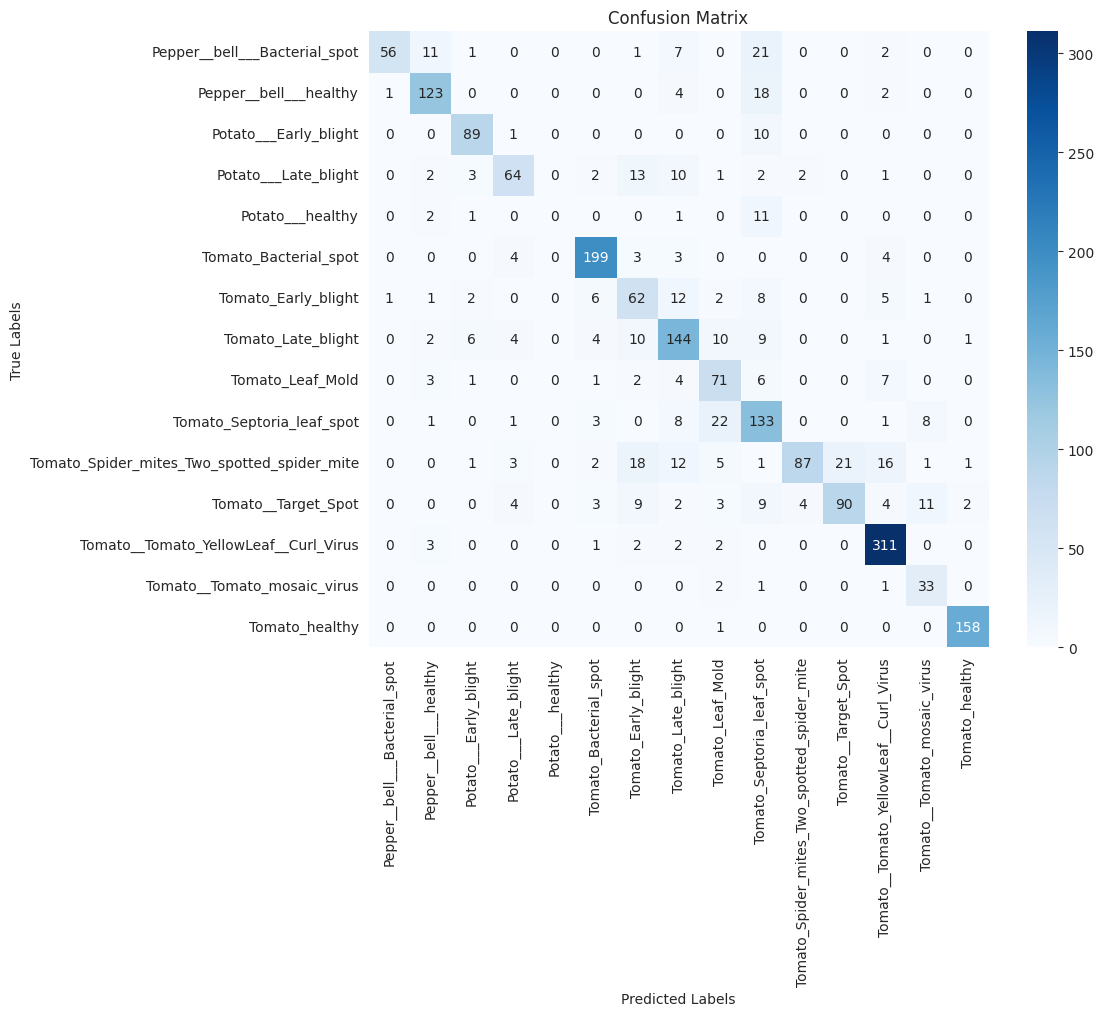

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
import numpy as np

# Function to create the model without Dropout layers
def create_model_without_dropout(input_shape, class_count):
    input_tensor = Input(shape=input_shape)

    # Initial layers
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Define MobileNet block
    def mobilenet_block(x, filters, kernel_size, strides):
        x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    # Function to create a stage of MobileNet
    def stage(x, filters, repetitions, strides):
        x = mobilenet_block(x, filters=filters, kernel_size=3, strides=strides)
        for _ in range(repetitions - 1):
            x = mobilenet_block(x, filters=filters, kernel_size=3, strides=1)
        return x

    # Define the number of repetitions, filters, and strides for each stage
    repetitions = [3, 7, 3]
    filters = [64, 128, 256]
    strides = [1, 2, 2]

    # Build the model architecture without Dropout layers
    for reps, f, s in zip(repetitions, filters, strides):
        x = stage(x, filters=f, repetitions=reps, strides=s)

    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    output_tensor = Dense(class_count, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Example usage
input_shape = (224, 224, 3)  # Define input shape based on your dataset
class_count = len(train_gen.class_indices)  # Number of classes
model = create_model_without_dropout(input_shape, class_count)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# ***Ablation Study 3: Removing Regularization***

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
413/413 [==============================] - 54s 102ms/step - loss: 1.6264 - accuracy: 0.4668 - val_loss: 5.4147 - val_accuracy: 0.1555
Epoch 2/40
413/413 [==============================] - 42s 100ms/step - loss: 0.8938 - accuracy: 0.7056 - val_loss: 1.1159 - val_accuracy: 0.6250
Epoch 3/40
413/413 [==============================] - 43s 103ms/step - loss: 0.6318 - accuracy: 0.7904 - val_loss: 0.7749 - val_accuracy: 0.7369
Epoch 4/40
413/413 [==============================] - 42s 102ms/step - loss: 0.4801 - accuracy: 0.8380 - val_loss: 1.3025 - val_accuracy: 0.6328
Epoch 5/40
413/413 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8704 5 /40     0.391   87.038   1.22759  64.390   0.00100  0.00100  accuracy     3.87    43.02  
enter H to halt training or an integer for number of epochs to run then ask again


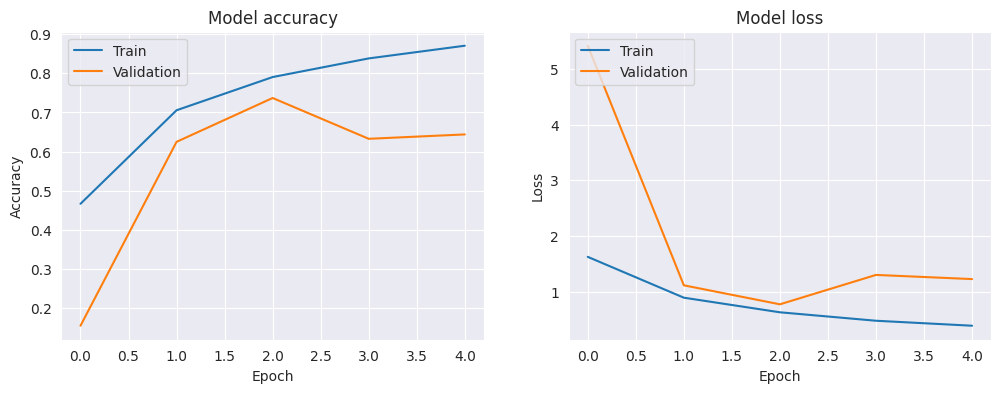

43/43 [==============================] - 4s 89ms/step - loss: 1.1954 - accuracy: 0.6366
Train Loss: 1.1486680507659912 Train Accuracy: 0.6502725481987
Validation Loss: 1.2275875806808472 Validation Accuracy: 0.6438953280448914
Test Loss: 1.1953545808792114 Test Accuracy: 0.6366279125213623
43/43 [==============================] - 5s 95ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.25      1.00      0.40        99
                     Pepper__bell___healthy       0.88      0.57      0.69       148
                      Potato___Early_blight       0.80      0.70      0.74       100
                       Potato___Late_blight       0.93      0.64      0.76       100
                           Potato___healthy       0.88      0.47      0.61        15
                      Tomato_Bacterial_spot       0.98      0.82      0.89       213
                        Tomato_Early

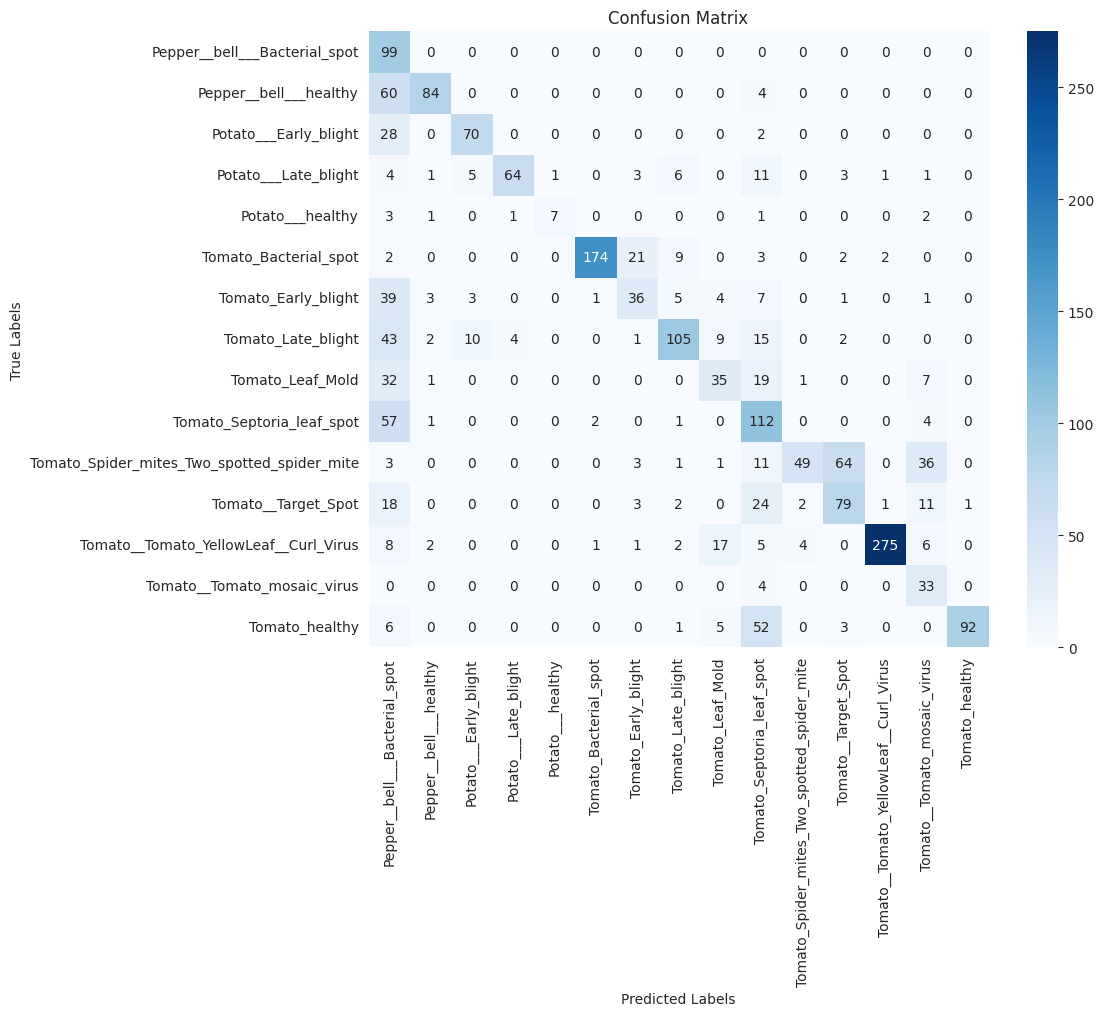

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
import numpy as np

# Function to create the model without regularization
def create_model_without_regularization(input_shape, class_count):
    input_tensor = Input(shape=input_shape)

    # Initial layers
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Define MobileNet block
    def mobilenet_block(x, filters, kernel_size, strides):
        x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    # Function to create a stage of MobileNet
    def stage(x, filters, repetitions, strides):
        x = mobilenet_block(x, filters=filters, kernel_size=3, strides=strides)
        for _ in range(repetitions - 1):
            x = mobilenet_block(x, filters=filters, kernel_size=3, strides=1)
        return x

    # Define the number of repetitions, filters, and strides for each stage
    repetitions = [3, 7, 3]
    filters = [64, 128, 256]
    strides = [1, 2, 2]

    # Build the model architecture without regularization
    for reps, f, s in zip(repetitions, filters, strides):
        x = stage(x, filters=f, repetitions=reps, strides=s)

    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Removed regularizers
    output_tensor = Dense(class_count, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Example usage
input_shape = (224, 224, 3)  # Define input shape based on your dataset
class_count = len(train_gen.class_indices)  # Number of classes
model = create_model_without_regularization(input_shape, class_count)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
